# SWB Computational Models

- Winning model from 2014 "A computational and neural model of momentary subjective well-being"
- Adapted to include counterfactual information 

Created: 05/04/2023 by Alie Fink
Updated: 01/14/2024

In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
import scipy
from scipy.optimize import least_squares, minimize
import sklearn
from sklearn.metrics import r2_score
import random
import tqdm
from scipy.stats import spearmanr, norm
import statsmodels.api as sm
import os
import pickle
import datetime
from joblib import Parallel, delayed
import itertools


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/swb_computational_modeling/swb_behav_models/scripts/')
import SWB_modeling_utils, SWB_behav_utils

In [5]:
# set directories
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/'
behav_dir = f'{base_dir}behavior_analysis/behavior_preprocessed/'
# create fig saving directory
fig_dir = f'{base_dir}swb_computational_modeling/swb_behav_models/figs/swb_pt_glms/'
os.makedirs(fig_dir,exist_ok = True) 

# get date info for data/fig saving
date = datetime.date.today().strftime('%m%d%Y')
print(date)

01152024


In [6]:
subj_list = pd.read_excel(f'{base_dir}SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0])
subj_ids = list(subj_list.PatientID)

In [7]:
bdi_list = pd.read_excel(f'{base_dir}SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
bai_list = pd.read_excel(f'{base_dir}SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[4])
bai_list = list(bai_list.SWB_BAI)

In [8]:
%matplotlib inline

#### set theme for all plots
sns.set_theme(style='ticks',font='Arial') 
sns.set_context("talk")

# Prospect Theory Parameters for SWB Subj
- save data into task dfs
- create regression df for ephys regression
- update model_data inputs for GLMs

In [8]:
# load subj fits for mle + em map 

pt_mle_fits = pickle.load(open(f'{base_dir}swb_computational_modeling/swb_behav_models/data/swb_pt_subj_fits/swb_pt_MLE_dict_01142024.pkl','rb'))
# pt_mle_fits
pt_emmap_fits = pickle.load(open(f'{base_dir}swb_computational_modeling/swb_behav_models/data/swb_pt_subj_fits/swb_pt_EMMAP_fit_subj_dicts_01142024.pkl','rb')) 
# pt_emmap_fits


In [9]:
# MLE 
# extract estimated params for all subj

risk_mle    = []
loss_mle    = []
invtemp_mle = []
negll_mle   = []
bic_mle     = []


for subj_id in subj_ids: 
    subj_data = pt_mle_fits[subj_id]['subj_dict']
    risk_mle.append(subj_data['params'][0])
    loss_mle.append(subj_data['params'][1])
    invtemp_mle.append(subj_data['params'][2])
    negll_mle.append(subj_data['negll'])
    bic_mle.append(subj_data['BIC'])
    

In [10]:
# EM MAP 
# extract estimated params for all subj

risk_emmap     = []
loss_emmap     = []
invtemp_emmap  = []
negll_emmap    = []
bic_emmap      = []


for subj_id in subj_ids: 
    subj_data = pt_emmap_fits[subj_id]
    risk_emmap.append(subj_data['params'][0])
    loss_emmap.append(subj_data['params'][1])
    invtemp_emmap.append(subj_data['params'][2])
    negll_emmap.append(subj_data['negll'])
    bic_emmap.append(subj_data['bic'])

In [11]:
# combine mle and emmap info into df + save

### make summary df of all pt info 
df_data_dict = {'subj_id':subj_ids,'risk_mle':risk_mle,'loss_mle':loss_mle,'invtemp_mle':invtemp_mle,'negll_mle':negll_mle,'bic_mle':bic_mle,
                'risk_emmap':risk_emmap,'loss_emmap':loss_emmap,'invtemp_emmap':invtemp_emmap,'negll_emmap':negll_emmap,'bic_emmap':bic_emmap,
                'bdi':bdi_list,'bai':bai_list}

pt_params_df = pd.DataFrame(df_data_dict)
pt_params_df.to_csv(f'{base_dir}swb_computational_modeling/swb_behav_models/data/swb_pt_subj_fits/pt_params_mle_emmap_df_{date}.csv')
    
pt_params_df

subj_id  risk_mle  loss_mle  invtemp_mle   negll_mle     bic_mle  \
0      DA8  1.212121  5.111117     2.625557   55.476387  125.984681   
1      DA9  1.484386  0.836855     3.261053   81.634586  178.301077   
2     DA10  0.781768  1.727190     3.058602   90.215432  195.462769   
3     DA11  1.199625  0.226255     1.527750   96.929642  208.891190   
4    DA023  0.994608  1.864381     2.089041   91.022847  197.077600   
5    DA026  0.564950  2.148784     2.429444   88.984904  193.001714   
6    MS002  0.817053  3.421697     1.387247   88.149899  191.331703   
7    MS003  0.733124  0.000010     5.115220   85.857590  186.747086   
8    MS004  0.711023  6.000000     0.316979  100.327488  215.686883   
9    MS016  0.623760  0.969737     6.760218   87.034070  189.100046   
10   MS017  1.325976  0.989178     6.336838   66.908907  148.849720   
11   MS019  1.141830  0.000010     6.782407   76.959423  168.950752   
12   MS020  0.676425  6.000000     0.532026   94.543918  204.119741   
13   MS022  1.921448  0.102132     3.493743   80.041619  175.115144   
14   MS025  0.852421  6.000000     1.103802   78.671177  172.374261   
15   MS026  1.442294  1.728298     1.999431   83.092609  181.217124   
16   MS027  0.641948  0.648616     5.595924   95.147044  205.325993   
17   MS029  0.000010  0.603728     0.722101  100.012237  215.056380   
18   MS030  0.732821  1.144258     5.357345   90.226620  195.485147   
19   MS033  2.000000  0.222575     5.713790   71.600376  158.232658   
20   MS035  1.570579  0.384711     1.056864   98.926805  212.885516   

    risk_emmap  loss_emmap  invtemp_emmap  negll_emmap   bic_emmap  bdi  bai  
0     1.161590    3.666231       3.541822    55.963529  126.958964   13    0  
1     1.334604    0.818940       3.696060    81.946609  178.925124   32    0  
2     0.795437    1.659771       3.196416    90.240148  195.512203   11    0  
3     1.000752    0.429149       2.297940    97.347112  209.726129   41    0  
4     0.965702    1.693014       2.521667    91.145881  197.323668   14    0  
5     0.590956    1.870426       3.037436    89.119384  193.270674   19   36  
6     0.805767    2.295807       2.387465    88.556058  192.144022   14    0  
7     0.759944    0.128203       4.769846    86.927146  188.886198    8    0  
8     0.691662    1.803040       1.626593   101.776484  218.584874    7    4  
9     0.645710    1.001507       5.244064    87.523735  190.079377   10    5  
10    1.310502    1.033441       5.448675    67.226271  149.484448   26   27  
11    1.085923    0.055000       5.389756    79.274083  173.580072   12   36  
12    0.619805    2.133603       2.046961    95.674040  206.379985    6   13  
13    1.256236    0.259534       4.408286    81.049777  177.131460   10   11  
14    0.807489    3.847333       1.864738    80.558145  176.148196   10    7  
15    1.269594    1.567005       2.596427    83.525158  182.082222    9   11  
16    0.672626    0.657759       4.593937    95.403142  205.838189   22   16  
17    0.562642    0.661961       2.407309   100.628346  216.288599   32   23  
18    0.763999    1.157057       4.559907    90.411293  195.854492   19   15  
19    1.437549    0.397883       5.382436    73.651990  162.335886   39   42  
20    1.018185    0.730962       2.184444    99.588768  214.209442   15   10

In [12]:
# summary stats for fit quality
    # param means
    # param ranges
    # params @ bounds

pt_summary_df = {'risk_mle_mean':np.mean(risk_mle),'risk_mle_min':np.min(risk_mle),'risk_mle_max':np.max(risk_mle),
              'n_risk_bad_mle':[np.sum(pt_params_df.risk_mle==2)+np.sum(pt_params_df.risk_mle==0.00001)],
              'loss_mle_mean':np.mean(loss_mle),'loss_mle_min':np.min(loss_mle),'loss_mle_max':np.max(loss_mle),
              'n_loss_bad_mle':[np.sum(pt_params_df.loss_mle==6)+np.sum(pt_params_df.loss_mle==0.00001)],
              'invtemp_mle_mean':np.mean(invtemp_mle),'invtemp_mle_min':np.min(invtemp_mle),'invtemp_mle_max':np.max(invtemp_mle),
              'n_invtemp_bad_mle':[np.sum(pt_params_df.invtemp_mle==10)+np.sum(pt_params_df.invtemp_mle==0.00001)],
              'bic_mean_mle':np.mean(bic_mle),'bic_min_mle':np.min(bic_mle),'bic_max_mle':np.max(bic_mle),
              'negll_mean_mle':np.mean(negll_mle),'negll_min_mle':np.min(negll_mle),'negll_max_mle':np.max(negll_mle),
#
              'risk_emmap_mean':np.mean(risk_emmap),'risk_emmap_min':np.min(risk_emmap),'risk_emmap_max':np.max(risk_emmap),
              'n_risk_bad_emmap':[np.sum(pt_params_df.risk_emmap==2)+np.sum(pt_params_df.risk_emmap==0.00001)],
              'loss_emmap_mean':np.mean(loss_emmap),'loss_emmap_min':np.min(loss_emmap),'loss_emmap_max':np.max(loss_emmap),
              'n_loss_bad_emmap':[np.sum(pt_params_df.loss_emmap==6)+np.sum(pt_params_df.loss_emmap==0.00001)],
              'invtemp_emmap_mean':np.mean(invtemp_emmap),'invtemp_emmap_min':np.min(invtemp_emmap),'invtemp_emmap_max':np.max(invtemp_emmap),
              'n_invtemp_bad_emmap':[np.sum(pt_params_df.invtemp_emmap==10)+np.sum(pt_params_df.invtemp_emmap==0.00001)],
              'bic_mean_emmap':np.mean(bic_emmap),'bic_min_emmap':np.min(bic_emmap),'bic_max_emmap':np.max(bic_emmap),
              'negll_mean_emmap':np.mean(negll_emmap),'negll_min_emmap':np.min(negll_emmap),'negll_max_emmap':np.max(negll_emmap)}


pt_summary_df = pd.DataFrame(pt_summary_df)
pt_summary_df.to_csv(f'{base_dir}swb_computational_modeling/swb_behav_models/data/swb_pt_subj_fits/pt_summary_mle_emmap_df_{date}.csv')


In [13]:
all_pt_data = {}

for subj_id in subj_ids: 
    # get mle df 
    mle_data = pt_mle_fits[subj_id]['subj_dict']
    # get emmap df 
    emmap_data = pt_emmap_fits[subj_id]
    all_pt_data[subj_id] = {'mle_data':mle_data,
                            'emmap_data':emmap_data
                            }
    

In [38]:
pt_task_dfs = SWB_modeling_utils.get_pt_task_data_mle_emmap(subj_ids,behav_dir,pt_mle_fits,pt_emmap_fits)
# pt_task_dfs

## Visualize Param Fits from MLE and EM MAP

In [15]:
pt_params_df

subj_id  risk_mle  loss_mle  invtemp_mle   negll_mle     bic_mle  \
0      DA8  1.212121  5.111117     2.625557   55.476387  125.984681   
1      DA9  1.484386  0.836855     3.261053   81.634586  178.301077   
2     DA10  0.781768  1.727190     3.058602   90.215432  195.462769   
3     DA11  1.199625  0.226255     1.527750   96.929642  208.891190   
4    DA023  0.994608  1.864381     2.089041   91.022847  197.077600   
5    DA026  0.564950  2.148784     2.429444   88.984904  193.001714   
6    MS002  0.817053  3.421697     1.387247   88.149899  191.331703   
7    MS003  0.733124  0.000010     5.115220   85.857590  186.747086   
8    MS004  0.711023  6.000000     0.316979  100.327488  215.686883   
9    MS016  0.623760  0.969737     6.760218   87.034070  189.100046   
10   MS017  1.325976  0.989178     6.336838   66.908907  148.849720   
11   MS019  1.141830  0.000010     6.782407   76.959423  168.950752   
12   MS020  0.676425  6.000000     0.532026   94.543918  204.119741   
13   MS022  1.921448  0.102132     3.493743   80.041619  175.115144   
14   MS025  0.852421  6.000000     1.103802   78.671177  172.374261   
15   MS026  1.442294  1.728298     1.999431   83.092609  181.217124   
16   MS027  0.641948  0.648616     5.595924   95.147044  205.325993   
17   MS029  0.000010  0.603728     0.722101  100.012237  215.056380   
18   MS030  0.732821  1.144258     5.357345   90.226620  195.485147   
19   MS033  2.000000  0.222575     5.713790   71.600376  158.232658   
20   MS035  1.570579  0.384711     1.056864   98.926805  212.885516   

    risk_emmap  loss_emmap  invtemp_emmap  negll_emmap   bic_emmap  bdi  bai  
0     1.161590    3.666231       3.541822    55.963529  126.958964   13    0  
1     1.334604    0.818940       3.696060    81.946609  178.925124   32    0  
2     0.795437    1.659771       3.196416    90.240148  195.512203   11    0  
3     1.000752    0.429149       2.297940    97.347112  209.726129   41    0  
4     0.965702    1.693014       2.521667    91.145881  197.323668   14    0  
5     0.590956    1.870426       3.037436    89.119384  193.270674   19   36  
6     0.805767    2.295807       2.387465    88.556058  192.144022   14    0  
7     0.759944    0.128203       4.769846    86.927146  188.886198    8    0  
8     0.691662    1.803040       1.626593   101.776484  218.584874    7    4  
9     0.645710    1.001507       5.244064    87.523735  190.079377   10    5  
10    1.310502    1.033441       5.448675    67.226271  149.484448   26   27  
11    1.085923    0.055000       5.389756    79.274083  173.580072   12   36  
12    0.619805    2.133603       2.046961    95.674040  206.379985    6   13  
13    1.256236    0.259534       4.408286    81.049777  177.131460   10   11  
14    0.807489    3.847333       1.864738    80.558145  176.148196   10    7  
15    1.269594    1.567005       2.596427    83.525158  182.082222    9   11  
16    0.672626    0.657759       4.593937    95.403142  205.838189   22   16  
17    0.562642    0.661961       2.407309   100.628346  216.288599   32   23  
18    0.763999    1.157057       4.559907    90.411293  195.854492   19   15  
19    1.437549    0.397883       5.382436    73.651990  162.335886   39   42  
20    1.018185    0.730962       2.184444    99.588768  214.209442   15   10

In [16]:
risk_corr, risk_p = spearmanr(pt_params_df.risk_mle, pt_params_df.risk_emmap)
print('Spearman correlation: %.3f' % risk_corr)
print(risk_p)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Spearman correlation: 0.960
6.238818356262163e-12


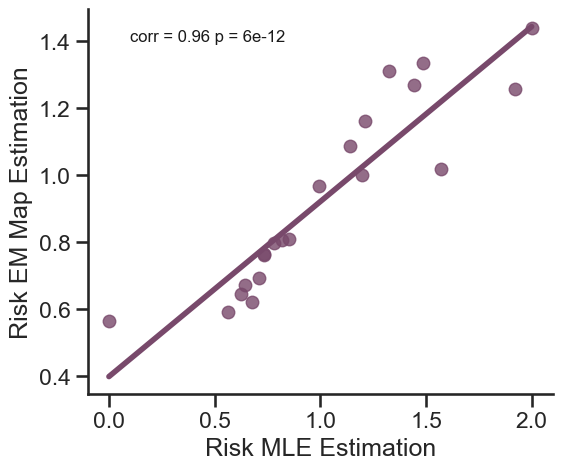

In [17]:
## MLE vs EM MAP Risk Estimations
# plt.scatter(subj_bdi,risk_est,color = '#78496b')
fig,ax = plt.subplots(figsize=(6,5))

sns.regplot(ax=ax,x=pt_params_df.risk_mle, y=pt_params_df.risk_emmap,color = '#78496b',ci=None,scatter=True,line_kws={"linewidth": 4})
ax.text(0.1, 1.4,f'corr = {np.round(risk_corr,2)} p = {np.round(risk_p,12)}',fontsize=12,color = 'k')
plt.xlabel('Risk MLE Estimation')
plt.ylabel('Risk EM Map Estimation')
sns.despine()


plt.savefig(f'{fig_dir}risk_mle_emmap_corr_{date}.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

In [18]:
loss_corr, loss_p = spearmanr(pt_params_df.loss_mle, pt_params_df.loss_emmap)
print('Spearman correlation: %.3f' % loss_corr)
print(loss_p)

Spearman correlation: 0.974Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

1.1702563698328304e-13


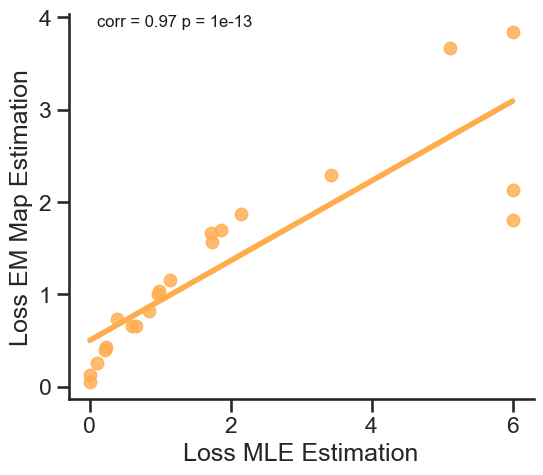

In [19]:
## MLE vs EM MAP Risk Estimations
# plt.scatter(subj_bdi,risk_est,color = '#78496b')
fig,ax = plt.subplots(figsize=(6,5))

sns.regplot(ax=ax,x=pt_params_df.loss_mle, y=pt_params_df.loss_emmap,color = '#ffac4d',ci=None,scatter=True,line_kws={"linewidth": 4})
ax.text(0.1, 3.9,f'corr = {np.round(loss_corr,2)} p = {np.round(loss_p,13)}',fontsize=12,color = 'k')
plt.xlabel('Loss MLE Estimation')
plt.ylabel('Loss EM Map Estimation')
sns.despine()


plt.savefig(f'{fig_dir}loss_mle_emmap_corr_{date}.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

In [20]:
invtemp_corr, invtemp_p = spearmanr(pt_params_df.invtemp_mle, pt_params_df.invtemp_emmap)
print('Spearman correlation: %.3f' % invtemp_corr)
print(invtemp_p)

Spearman correlation: 0.968Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

8.33318722559804e-13


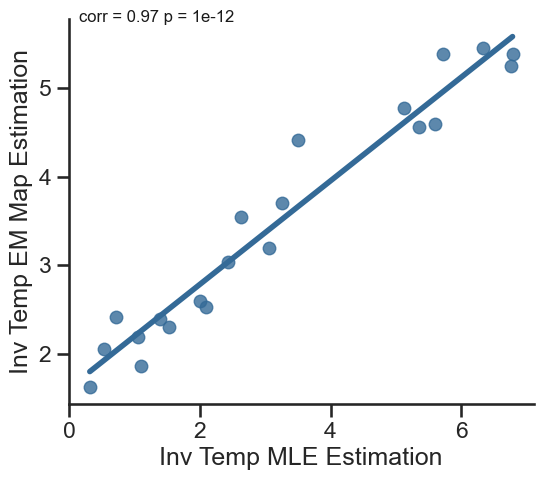

In [21]:
## MLE vs EM MAP Risk Estimations
# plt.scatter(subj_bdi,risk_est,color = '#78496b')
fig,ax = plt.subplots(figsize=(6,5))

sns.regplot(ax=ax,x=pt_params_df.invtemp_mle, y=pt_params_df.invtemp_emmap,color = '#346a97',ci=None,scatter=True,line_kws={"linewidth": 4})
ax.text(0.15, 5.75,f'corr = {np.round(invtemp_corr,2)} p = {np.round(invtemp_p,12)}',fontsize=12,color = 'k')
plt.xlabel('Inv Temp MLE Estimation')
plt.ylabel('Inv Temp EM Map Estimation')
sns.despine()


plt.savefig(f'{fig_dir}invtemp_mle_emmap_corr_{date}.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

In [22]:
pt_params_df

subj_id  risk_mle  loss_mle  invtemp_mle   negll_mle     bic_mle  \
0      DA8  1.212121  5.111117     2.625557   55.476387  125.984681   
1      DA9  1.484386  0.836855     3.261053   81.634586  178.301077   
2     DA10  0.781768  1.727190     3.058602   90.215432  195.462769   
3     DA11  1.199625  0.226255     1.527750   96.929642  208.891190   
4    DA023  0.994608  1.864381     2.089041   91.022847  197.077600   
5    DA026  0.564950  2.148784     2.429444   88.984904  193.001714   
6    MS002  0.817053  3.421697     1.387247   88.149899  191.331703   
7    MS003  0.733124  0.000010     5.115220   85.857590  186.747086   
8    MS004  0.711023  6.000000     0.316979  100.327488  215.686883   
9    MS016  0.623760  0.969737     6.760218   87.034070  189.100046   
10   MS017  1.325976  0.989178     6.336838   66.908907  148.849720   
11   MS019  1.141830  0.000010     6.782407   76.959423  168.950752   
12   MS020  0.676425  6.000000     0.532026   94.543918  204.119741   
13   MS022  1.921448  0.102132     3.493743   80.041619  175.115144   
14   MS025  0.852421  6.000000     1.103802   78.671177  172.374261   
15   MS026  1.442294  1.728298     1.999431   83.092609  181.217124   
16   MS027  0.641948  0.648616     5.595924   95.147044  205.325993   
17   MS029  0.000010  0.603728     0.722101  100.012237  215.056380   
18   MS030  0.732821  1.144258     5.357345   90.226620  195.485147   
19   MS033  2.000000  0.222575     5.713790   71.600376  158.232658   
20   MS035  1.570579  0.384711     1.056864   98.926805  212.885516   

    risk_emmap  loss_emmap  invtemp_emmap  negll_emmap   bic_emmap  bdi  bai  
0     1.161590    3.666231       3.541822    55.963529  126.958964   13    0  
1     1.334604    0.818940       3.696060    81.946609  178.925124   32    0  
2     0.795437    1.659771       3.196416    90.240148  195.512203   11    0  
3     1.000752    0.429149       2.297940    97.347112  209.726129   41    0  
4     0.965702    1.693014       2.521667    91.145881  197.323668   14    0  
5     0.590956    1.870426       3.037436    89.119384  193.270674   19   36  
6     0.805767    2.295807       2.387465    88.556058  192.144022   14    0  
7     0.759944    0.128203       4.769846    86.927146  188.886198    8    0  
8     0.691662    1.803040       1.626593   101.776484  218.584874    7    4  
9     0.645710    1.001507       5.244064    87.523735  190.079377   10    5  
10    1.310502    1.033441       5.448675    67.226271  149.484448   26   27  
11    1.085923    0.055000       5.389756    79.274083  173.580072   12   36  
12    0.619805    2.133603       2.046961    95.674040  206.379985    6   13  
13    1.256236    0.259534       4.408286    81.049777  177.131460   10   11  
14    0.807489    3.847333       1.864738    80.558145  176.148196   10    7  
15    1.269594    1.567005       2.596427    83.525158  182.082222    9   11  
16    0.672626    0.657759       4.593937    95.403142  205.838189   22   16  
17    0.562642    0.661961       2.407309   100.628346  216.288599   32   23  
18    0.763999    1.157057       4.559907    90.411293  195.854492   19   15  
19    1.437549    0.397883       5.382436    73.651990  162.335886   39   42  
20    1.018185    0.730962       2.184444    99.588768  214.209442   15   10

In [30]:
negll_mle_cat = ['MLE']*len(pt_params_df)
negll_emmap_cat = ['EM MAP']*len(pt_params_df)
negll_cat = negll_mle_cat + negll_emmap_cat

negll_mle_data = list(pt_params_df.negll_mle) + list(pt_params_df.negll_emmap)
# negll_mle_data


negll_plot_data = pd.DataFrame({'negll':negll_mle_data,'method':negll_cat})
# negll_plot_data

In [31]:
print('MLE Negll Mean = ',np.mean(pt_params_df.negll_mle))

print('EM MAP Negll Mean = ',np.mean(pt_params_df.negll_emmap))

MLE Negll Mean =  85.79826576145643
EM MAP Negll Mean =  86.54938572045315


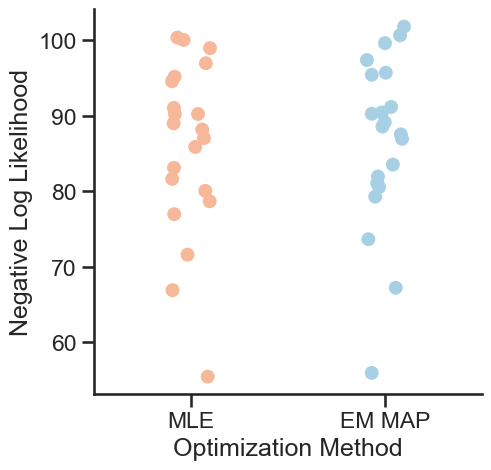

In [24]:
# negll comparisons 
    # heatmap - need to make grid of negll for risk & loss params -- later 

fig,ax = plt.subplots(figsize=(5,5))

sns.stripplot(
    data=negll_plot_data, x="method", y="negll", 
    alpha=1, legend=False, size=10, palette='RdBu'
)

plt.ylabel('Negative Log Likelihood')
plt.xlabel('Optimization Method')
sns.despine()


plt.savefig(f'{fig_dir}negll_mle_emmap_{date}.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 


In [28]:
bic_mle_cat = ['MLE']*len(pt_params_df)
bic_emmap_cat = ['EM MAP']*len(pt_params_df)
bic_cat = bic_mle_cat + bic_emmap_cat

bic_data = list(pt_params_df.bic_mle) + list(pt_params_df.bic_emmap)
# negll_mle_data


bic_plot_data = pd.DataFrame({'bic':bic_data,'method':bic_cat})
# bic_plot_data

In [29]:
print('MLE BIC Mean = ',np.mean(pt_params_df.bic_mle))

print('EM MAP BIC Mean = ',np.mean(pt_params_df.bic_emmap))

MLE BIC Mean =  186.62843740520162
EM MAP BIC Mean =  188.13067732319507


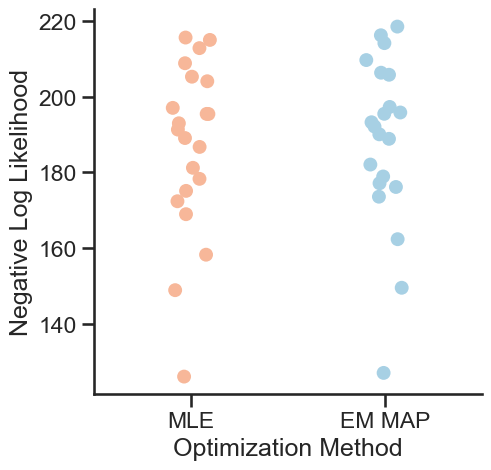

In [26]:
# bic comparisons 

fig,ax = plt.subplots(figsize=(5,5))

sns.stripplot(
    data=bic_plot_data, x="method", y="bic", 
    alpha=1, legend=False, size=10, palette='RdBu'
)

plt.ylabel('Negative Log Likelihood')
plt.xlabel('Optimization Method')
sns.despine()


plt.savefig(f'{fig_dir}bic_mle_emmap_{date}.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

# GLMs


## Debugging GLM Fitting Functions

#### Create all subj model data df 

In [13]:
### load all subj data

master_subj_info = {}

for subj_id in subj_ids:
    #data loading
    task = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
    rate = pd.read_csv(f'{behav_dir}{subj_id}_rate_data')
    #gamble plot info
    loss,mix,gain = SWB_behav_utils.norm_gamble_choices(task)

    master_subj_info[subj_id] = {'task':task,'rate':rate,
                                 'loss':loss, 'mix':mix,'gain':gain
                                 }



In [14]:
model_data_vars = ['SafeBet','LowBet', 'HighBet',
       'GambleChoice', 'Outcome', 'Profit', 'TotalProfit', 'GambleEV', 'CR',
       'choiceEV', 'RPE', 'totalCPE', 'decisionCPE', 'totalRegret',
       'decisionRegret', 'totalRelief', 'decisionRelief', 'totalCF',
       'decisionCF', 'pRPE', 'nRPE', 'util_safe_mle', 'util_gamble_mle',
       'wSafe_mle', 'wHigh_mle', 'wLow_mle', 'p_safe_mle', 'p_gamble_mle',
       'util_safe_emmap', 'util_gamble_emmap', 'wSafe_emmap', 'wHigh_emmap',
       'wLow_emmap', 'p_safe_emmap', 'p_gamble_emmap', 'util_tCPE_mle',
       'util_dCPE_mle', 'util_tCF_mle', 'util_dCF_mle', 'util_tRegret_mle',
       'util_dRegret_mle', 'util_tRelief_mle', 'util_dRelief_mle',
       'util_RPE_mle', 'util_pRPE_mle', 'util_nRPE_mle', 'util_tCPE_emmap',
       'util_dCPE_emmap', 'util_tCF_emmap', 'util_dCF_emmap',
       'util_tRegret_emmap', 'util_dRegret_emmap', 'util_tRelief_emmap',
       'util_dRelief_emmap', 'util_RPE_emmap', 'util_pRPE_emmap',
       'util_nRPE_emmap']

In [15]:
# update model data here w pt 

all_subj_model_data = {} #make dictionary with keys as subjects names, each one containing a dictionary with keys that are column names for larger df 

model_data_keys = []
for var in model_data_vars:
    t1_col = var + '_t-1' 
    t2_col = var + '_t-2'
    t3_col = var + '_t-3'
    model_data_keys.append(t1_col)
    model_data_keys.append(t2_col)
    model_data_keys.append(t3_col)

#create model data pandas df with model_data_dict_keys as column names 
model_df_col_names = ['subj_id','round','rate','z_rate','bdi','bai'] + model_data_keys
all_subj_model_df = pd.DataFrame(columns = model_df_col_names)


for subj_id in subj_ids:
    subj_model_dict = SWB_modeling_utils.get_glm_data_single_subj(subj_id,behav_dir,model_data_vars)
    all_subj_model_data[subj_id] = subj_model_dict #in case dictionary of dictionaries is easier to work with later
    all_subj_model_df = pd.concat([all_subj_model_df,pd.DataFrame(subj_model_dict)])

all_subj_model_df.to_csv(f'{base_dir}swb_computational_modeling/swb_behav_models/data/glm_inputs/all_subj_model_df_{date}.csv')

## GLMs with Model-Free Parameter Inputs

### Base Models:
1) Base       (CR+EV)
2) RPE        (CR+EV+RPE)
3) nRPE       (CR+EV+nRPE)
4) pRPE       (CR+EV+pRPE)
5) nRPE_pRPE  (CR+EV+nRPE+pRPE)
6) EV_RPE     (EV+RPE)
7) CR_RPE     (CR+RPE)
8)  tCPE      (CR+EV+tCPE) 
9)  dCPE      (CR+EV+dCPE) 
10) RPE_tCPE  (CR+EV+RPE+tCPE)
11) RPE_dCPE  (CR+EV+RPE+dCPE)
12) tRegret   (CR+EV+tRegret)
13) dRegret   (CR+EV+dRegret)
14) tRelief   (CR+EV+tRelief)
15) dRelief   (CR+EV+dRelief)
16) nRPE_tReg (CR+EV+nRPE+tRegret)
17) nRPE_dReg (CR+EV+nRPE+dRegret)
18) pRPE_tRel (CR+EV+pRPE+tRelief)
19) pRPE_dRel (CR+EV+pRPE+dRelief)
20) nRPE_tReg_pRPE_tRel (CR+EV+nRPE+pRPE+tRegret+tRelief)
21) nRPE_dReg_pRPE_dRel (CR+EV+nRPE+pRPE+dRegret+dRelief)

### Utility Models: (EM MAP Fits)
22) Base_util      (util_s+util_g)
23) RPE_util       (util_s+util_g+util_RPE)
24) tCPE_util      (util_s+util_g+util_tCPE)
25) dCPE_util      (util_s+util_g+util_dCPE)
26) tCPE_RPE_util  (util_s+util_g+util_RPE+util_tCPE)
27) dCPE_RPE_util  (util_s+util_g+util_RPE+util_dCPE)
28) tRegret_util   (util_s+util_g+util_tRegret)
29) dRegret_util   (util_s+util_g+util_dRegret)
30) tRelief_util   (util_s+util_g+util_tRelief)
31) dRelief_util   (util_s+util_g+util_dRelief)
32) tReg_tRel_util (util_s+util_g+util_tRegret+util_tRelief)
33) dReg_dRel_util (util_s+util_g+util_dRegret+util_dRelief)
34) nRPE_tReg_util (util_s+util_g+util_nRPE+util_tRegret)
35) nRPE_dReg_util (util_s+util_g+util_nRPE+util_dRegret)
36) pRPE_tRel_util (util_s+util_g+util_pRPE+util_tRelief)
37) pRPE_dRel_util (util_s+util_g+util_pRPE+util_dRelief)
38) nRPE_pRPE_tReg_tRel_util (util_s+util_g+util_nRPE+util_pRPE+util_tRegret+util_tRelief)
39) nRPE_pRPE_dReg_dRel_util (util_s+util_g+util_nRPE+util_pRPE+util_dRegret+util_dRelief)

### Mixed Models:
40) Base_util_RPE        (util_s+util_g+RPE)
41) Base_util_nRPE       (util_s+util_g+nRPE)
42) Base_util_pRPE       (util_s+util_g+pRPE)
43) Base_util_tCPE       (util_s+util_g+tCPE)
44) Base_util_dCPE       (util_s+util_g+dCPE)
45) Base_util_tRegret    (util_s+util_g+tRegret)
46) Base_util_dRegret    (util_s+util_g+dRegret)
47) Base_util_tRelief    (util_s+util_g+tRelief)
48) Base_util_dRelief    (util_s+util_g+dRelief)
49) Base_util_RPE_tCPE   (util_s+util_g+RPE+tCPE)
50) Base_util_RPE_dCPE   (util_s+util_g+RPE+dCPE)
51) Base_util_tRegret_tRelief (util_s+util_g+tRegret+tRelief)
52) Base_util_dRegret_dRelief (util_s+util_g+dRegret+dRelief)
53) Base_util_nRPE_tRegret_pRPE_tRelief (util_s+util_g+nRPE+tRegret+pRPE+tRelief)
54) Base_util_nRPE_dRegret_pRPE_dRelief (util_s+util_g+nRPE+dRegret+pRPE+dRelief)

In [89]:
models_dict = {}
#base models 
models_dict['Base']                = ['CR','choiceEV']
models_dict['RPE']                 = ['CR','choiceEV','RPE']
models_dict['nRPE']                = ['CR','choiceEV','nRPE']
models_dict['pRPE']                = ['CR','choiceEV','pRPE']
models_dict['nRPE_pRPE']           = ['CR','choiceEV','nRPE','pRPE']
models_dict['EV_RPE']              = ['choiceEV','RPE']
models_dict['CR_RPE']              = ['CR','RPE']
models_dict['tCPE']                = ['CR','choiceEV','totalCPE']
models_dict['dCPE']                = ['CR','choiceEV','decisionCPE']
models_dict['RPE_tCPE']            = ['CR','choiceEV','RPE','totalCPE']
models_dict['RPE_dCPE']            = ['CR','choiceEV','RPE','decisionCPE']
models_dict['tRegret']             = ['CR','choiceEV','totalRegret']
models_dict['dRegret']             = ['CR','choiceEV','decisionRegret']
models_dict['tRelief']             = ['CR','choiceEV','totalRelief']
models_dict['dRelief']             = ['CR','choiceEV','decisionRelief']
models_dict['nRPE_tReg']           = ['CR','choiceEV','nRPE','totalRegret']
models_dict['nRPE_dReg']           = ['CR','choiceEV','nRPE','decisionRegret']
models_dict['pRPE_tRel']           = ['CR','choiceEV','pRPE','totalRelief']
models_dict['pRPE_dRel']           = ['CR','choiceEV','pRPE','decisionRelief']
models_dict['nRPE_tReg_pRPE_tRel'] = ['CR','choiceEV','nRPE','totalRegret','pRPE','totalRelief']
models_dict['nRPE_dReg_pRPE_dRel'] = ['CR','choiceEV','nRPE','decisionRegret','pRPE','decisionRelief']
#utility models
models_dict['Base_util']                = ['util_safe_emmap','util_gamble_emmap']
models_dict['RPE_util']                 = ['util_safe_emmap','util_gamble_emmap','util_RPE_emmap']
models_dict['tCPE_util']                = ['util_safe_emmap','util_gamble_emmap','util_tCPE_emmap']
models_dict['dCPE_util']                = ['util_safe_emmap','util_gamble_emmap','util_dCPE_emmap']
models_dict['tCPE_RPE_util']            = ['util_safe_emmap','util_gamble_emmap','util_RPE_emmap','util_tCPE_emmap']
models_dict['dCPE_RPE_util']            = ['util_safe_emmap','util_gamble_emmap','util_RPE_emmap','util_dCPE_emmap']
models_dict['tRegret_util']             = ['util_safe_emmap','util_gamble_emmap','util_tRegret_emmap']
models_dict['dRegret_util']             = ['util_safe_emmap','util_gamble_emmap','util_dRegret_emmap']
models_dict['tRelief_util']             = ['util_safe_emmap','util_gamble_emmap','util_tRelief_emmap']
models_dict['dRelief_util']             = ['util_safe_emmap','util_gamble_emmap','util_dRelief_emmap']
models_dict['tReg_tRel_util']           = ['util_safe_emmap','util_gamble_emmap','util_tRegret_emmap','util_tRelief_emmap']
models_dict['dReg_dRel_util']           = ['util_safe_emmap','util_gamble_emmap','util_dRegret_emmap','util_dRelief_emmap']
models_dict['nRPE_tReg_util']           = ['util_safe_emmap','util_gamble_emmap','util_nRPE_emmap','util_tRegret_emmap']
models_dict['nRPE_dReg_util']           = ['util_safe_emmap','util_gamble_emmap','util_nRPE_emmap','util_dRegret_emmap']
models_dict['pRPE_tRel_util']           = ['util_safe_emmap','util_gamble_emmap','util_pRPE_emmap','util_tRelief_emmap']
models_dict['pRPE_dRel_util']           = ['util_safe_emmap','util_gamble_emmap','util_pRPE_emmap','util_dRelief_emmap']
# naming is a typo for these: 
models_dict['nRPE_pRPE_tReg_tRel_util'] = ['util_safe_emmap','util_gamble_emmap','util_nRPE_emmap','util_tRegret_emmap','util_pRPE_emmap','util_tRelief_emmap']
models_dict['nRPE_pRPE_dReg_dRel_util'] = ['util_safe_emmap','util_gamble_emmap','util_nRPE_emmap','util_dRegret_emmap','util_pRPE_emmap','util_dRelief_emmap']
#fixing typo - 
models_dict['nRPE_tReg_pRPE_tRel_util'] = ['util_safe_emmap','util_gamble_emmap','util_nRPE_emmap','util_tRegret_emmap','util_pRPE_emmap','util_tRelief_emmap']
models_dict['nRPE_dReg_pRPE_dRel_util'] = ['util_safe_emmap','util_gamble_emmap','util_nRPE_emmap','util_dRegret_emmap','util_pRPE_emmap','util_dRelief_emmap']
#mixed models
models_dict['Base_util_RPE']                       = ['util_safe_emmap','util_gamble_emmap','RPE']
models_dict['Base_util_nRPE']                      = ['util_safe_emmap','util_gamble_emmap','nRPE']
models_dict['Base_util_pRPE']                      = ['util_safe_emmap','util_gamble_emmap','pRPE']
models_dict['Base_util_tCPE']                      = ['util_safe_emmap','util_gamble_emmap','totalCPE']
models_dict['Base_util_dCPE']                      = ['util_safe_emmap','util_gamble_emmap','decisionCPE']
models_dict['Base_util_tRegret']                   = ['util_safe_emmap','util_gamble_emmap','totalRegret']
models_dict['Base_util_dRegret']                   = ['util_safe_emmap','util_gamble_emmap','decisionRegret']
models_dict['Base_util_tRelief']                   = ['util_safe_emmap','util_gamble_emmap','totalRelief']
models_dict['Base_util_dRelief']                   = ['util_safe_emmap','util_gamble_emmap','decisionRelief']
models_dict['Base_util_RPE_tCPE']                  = ['util_safe_emmap','util_gamble_emmap','RPE','totalCPE']
models_dict['Base_util_RPE_dCPE']                  = ['util_safe_emmap','util_gamble_emmap','RPE','decisionCPE']
models_dict['Base_util_tRegret_tRelief']           = ['util_safe_emmap','util_gamble_emmap','totalRegret','totalRelief']
models_dict['Base_util_dRegret_dRelief']           = ['util_safe_emmap','util_gamble_emmap','decisionRegret','decisionRelief']
models_dict['Base_util_nRPE_tRegret_pRPE_tRelief'] = ['util_safe_emmap','util_gamble_emmap','nRPE','totalRegret','pRPE','totalRelief']
models_dict['Base_util_nRPE_dRegret_pRPE_dRelief'] = ['util_safe_emmap','util_gamble_emmap','nRPE','decisionRegret','pRPE','decisionRelief']


In [43]:
models_dict.keys()

dict_keys(['Base', 'RPE', 'nRPE', 'pRPE', 'nRPE_pRPE', 'EV_RPE', 'CR_RPE', 'tCPE', 'dCPE', 'RPE_tCPE', 'RPE_dCPE', 'tRegret', 'dRegret', 'tRelief', 'dRelief', 'nRPE_tReg', 'nRPE_dReg', 'pRPE_tRel', 'pRPE_dRel', 'nRPE_tReg_pRPE_tRel', 'nRPE_dReg_pRPE_dRel', 'Base_util', 'RPE_util', 'tCPE_util', 'dCPE_util', 'tCPE_RPE_util', 'dCPE_RPE_util', 'tRegret_util', 'dRegret_util', 'tRelief_util', 'dRelief_util', 'tReg_tRel_util', 'dReg_dRel_util', 'nRPE_tReg_util', 'nRPE_dReg_util', 'pRPE_tRel_util', 'pRPE_dRel_util', 'nRPE_pRPE_tReg_tRel_util', 'nRPE_pRPE_dReg_dRel_util', 'Base_util_RPE', 'Base_util_nRPE', 'Base_util_pRPE', 'Base_util_tCPE', 'Base_util_dCPE', 'Base_util_tRegret', 'Base_util_dRegret', 'Base_util_tRelief', 'Base_util_dRelief', 'Base_util_RPE_tCPE', 'Base_util_RPE_dCPE', 'Base_util_tRegret_tRelief', 'Base_util_dRegret_dRelief', 'Base_util_nRPE_tRegret_pRPE_tRelief', 'Base_util_nRPE_dRegret_pRPE_dRelief'])

# FIX FULL MODEL TYPO

In [76]:
fixing_models_dict = {}
fixing_models_dict['nRPE_tReg_pRPE_tRel_util'] = ['util_safe_emmap','util_gamble_emmap','util_nRPE_emmap','util_tRegret_emmap','util_pRPE_emmap','util_tRelief_emmap']
fixing_models_dict['nRPE_dReg_pRPE_dRel_util'] = ['util_safe_emmap','util_gamble_emmap','util_nRPE_emmap','util_dRegret_emmap','util_pRPE_emmap','util_dRelief_emmap']

# create list of all regressors in model data for each variable (t-1,t-2,t-3)
fixing_model_vars = {}

for model in fixing_models_dict.keys():
    model_regs = fixing_models_dict[model]
    full_var_list = []
    for var in model_regs:
        t1_col = var + '_t-1' 
        t2_col = var + '_t-2'
        t3_col = var + '_t-3'
        # add modified variable names to list - should match column names in all_subj_model_df
        full_var_list.append(t1_col)
        full_var_list.append(t2_col)
        full_var_list.append(t3_col)
    fixing_model_vars[model] = full_var_list

In [77]:
list(fixing_model_vars.keys())

['nRPE_tReg_pRPE_tRel_util', 'nRPE_dReg_pRPE_dRel_util']

In [78]:
#rerun model with lam bounds fixed - lower bound = 0.001 not zero!
fix_models = list(fixing_model_vars.keys())
fix_fit_dict = {}

for model_name in fix_models:
    #get model regressor info
    n_regs = len(fixing_models_dict[model_name])
    full_reg_list = fixing_model_vars[model_name]
    # create random param_inits for minimization
    n_inits = 100 # number of minimization iterations (100 took 45min)
    param_inits = []
    for n in range(n_inits):
        lambda_init = random.uniform(0, 1)
        betas_init = np.random.random(size = (n_regs+1))
        param_inits.append(np.hstack((lambda_init,betas_init)))
    #iterate through subjects using same initial parameters
    all_subj_fit_info = {}
    for subj_id in subj_ids:
        subj_df = all_subj_model_df[all_subj_model_df.subj_id==subj_id]
        subj_model_info = SWB_modeling_utils.min_rss_swb(subj_df,n_regs,full_reg_list,param_inits)
        all_subj_fit_info[subj_id] = subj_model_info
    fix_fit_dict[model_name] = all_subj_fit_info


In [ ]:
fix_fit_dict['nRPE_dReg_pRPE_dRel_util']

In [82]:
swb_model_fit_dict['nRPE_tReg_pRPE_tRel_util'] = fix_fit_dict['nRPE_tReg_pRPE_tRel_util']
swb_model_fit_dict['nRPE_dReg_pRPE_dRel_util'] = fix_fit_dict['nRPE_dReg_pRPE_dRel_util']

# Run All Models

In [10]:
# create list of all regressors in model data for each variable (t-1,t-2,t-3)
model_vars = {}

for model in models_dict.keys():
    model_regs = models_dict[model]
    full_var_list = []
    for var in model_regs:
        t1_col = var + '_t-1' 
        t2_col = var + '_t-2'
        t3_col = var + '_t-3'
        # add modified variable names to list - should match column names in all_subj_model_df
        full_var_list.append(t1_col)
        full_var_list.append(t2_col)
        full_var_list.append(t3_col)
    model_vars[model] = full_var_list


In [45]:
model_vars.keys()

dict_keys(['Base', 'RPE', 'nRPE', 'pRPE', 'nRPE_pRPE', 'EV_RPE', 'CR_RPE', 'tCPE', 'dCPE', 'RPE_tCPE', 'RPE_dCPE', 'tRegret', 'dRegret', 'tRelief', 'dRelief', 'nRPE_tReg', 'nRPE_dReg', 'pRPE_tRel', 'pRPE_dRel', 'nRPE_tReg_pRPE_tRel', 'nRPE_dReg_pRPE_dRel', 'Base_util', 'RPE_util', 'tCPE_util', 'dCPE_util', 'tCPE_RPE_util', 'dCPE_RPE_util', 'tRegret_util', 'dRegret_util', 'tRelief_util', 'dRelief_util', 'tReg_tRel_util', 'dReg_dRel_util', 'nRPE_tReg_util', 'nRPE_dReg_util', 'pRPE_tRel_util', 'pRPE_dRel_util', 'nRPE_pRPE_tReg_tRel_util', 'nRPE_pRPE_dReg_dRel_util', 'Base_util_RPE', 'Base_util_nRPE', 'Base_util_pRPE', 'Base_util_tCPE', 'Base_util_dCPE', 'Base_util_tRegret', 'Base_util_dRegret', 'Base_util_tRelief', 'Base_util_dRelief', 'Base_util_RPE_tCPE', 'Base_util_RPE_dCPE', 'Base_util_tRegret_tRelief', 'Base_util_dRegret_dRelief', 'Base_util_nRPE_tRegret_pRPE_tRelief', 'Base_util_nRPE_dRegret_pRPE_dRelief'])

In [147]:
#rerun model with lam bounds fixed - lower bound = 0.001 not zero!
all_models = list(model_vars.keys())
swb_model_fit_dict = {}

for model_name in all_models:
    #get model regressor info
    n_regs = len(models_dict[model_name])
    full_reg_list = model_vars[model_name]
    # create random param_inits for minimization
    n_inits = 100 # number of minimization iterations (100 took 45min)
    param_inits = []
    for n in range(n_inits):
        lambda_init = random.uniform(0, 1)
        betas_init = np.random.random(size = (n_regs+1))
        param_inits.append(np.hstack((lambda_init,betas_init)))
    #iterate through subjects using same initial parameters
    all_subj_fit_info = {}
    for subj_id in subj_ids:
        subj_df = all_subj_model_df[all_subj_model_df.subj_id==subj_id]
        subj_model_info = SWB_modeling_utils.min_rss_swb(subj_df,n_regs,full_reg_list,param_inits)
        all_subj_fit_info[subj_id] = subj_model_info
    swb_model_fit_dict[model_name] = all_subj_fit_info


In [148]:
swb_model_fit_dict

{'Base': {'DA8': {'best_result':   message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
     success: True
      status: 0
         fun: 36.561410206577
           x: [ 4.095e-01 -3.932e-01 -8.712e-01  1.595e+00]
         nit: 12
         jac: [ 2.132e-06  3.553e-06 -7.105e-07  7.105e-07]
        nfev: 85
        njev: 17
    hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>,
   'subj_dict': {'params': array([ 0.40952335, -0.39319233, -0.87118162,  1.59537801]),
    'reg_list': ['CR_t-1',
     'CR_t-2',
     'CR_t-3',
     'choiceEV_t-1',
     'choiceEV_t-2',
     'choiceEV_t-3'],
    'lam_method': 'exp',
    'mood_est': array([-0.37359199,  0.02379735, -0.58922903,  1.02241531, -0.14175506,
           -0.34917302,  0.19375108, -0.24335881, -0.33432916, -1.91505076,
            0.18920324, -0.22985619, -0.009372  ,  0.18709956, -0.45163446,
            0.55790851,  0.26463437, -0.10422769,  0.17749653, -0.03595625,
            0.40449667, -0.46617691,  0.55495046, -0.72845015

In [84]:
#### save estimation dict 
save_dir = f'{base_dir}swb_computational_modeling/swb_behav_models/data/glm_data/'
os.makedirs(save_dir,exist_ok = True) 
date = datetime.date.today().strftime('%m%d%Y')

# create a binary pickle file 
f = open(f'{save_dir}swb_glm_fit_dict_{date}.pkl',"wb")
# # write the python object (dict) to pickle file
pickle.dump(swb_model_fit_dict,f)
# # close file
f.close()

In [85]:
swb_model_fit_dict.keys()

dict_keys(['Base', 'RPE', 'nRPE', 'pRPE', 'nRPE_pRPE', 'EV_RPE', 'CR_RPE', 'tCPE', 'dCPE', 'RPE_tCPE', 'RPE_dCPE', 'tRegret', 'dRegret', 'tRelief', 'dRelief', 'nRPE_tReg', 'nRPE_dReg', 'pRPE_tRel', 'pRPE_dRel', 'nRPE_tReg_pRPE_tRel', 'nRPE_dReg_pRPE_dRel', 'Base_util', 'RPE_util', 'tCPE_util', 'dCPE_util', 'tCPE_RPE_util', 'dCPE_RPE_util', 'tRegret_util', 'dRegret_util', 'tRelief_util', 'dRelief_util', 'tReg_tRel_util', 'dReg_dRel_util', 'nRPE_tReg_util', 'nRPE_dReg_util', 'pRPE_tRel_util', 'pRPE_dRel_util', 'nRPE_pRPE_tReg_tRel_util', 'nRPE_pRPE_dReg_dRel_util', 'Base_util_RPE', 'Base_util_nRPE', 'Base_util_pRPE', 'Base_util_tCPE', 'Base_util_dCPE', 'Base_util_tRegret', 'Base_util_dRegret', 'Base_util_tRelief', 'Base_util_dRelief', 'Base_util_RPE_tCPE', 'Base_util_RPE_dCPE', 'Base_util_tRegret_tRelief', 'Base_util_dRegret_dRelief', 'Base_util_nRPE_tRegret_pRPE_tRelief', 'Base_util_nRPE_dRegret_pRPE_dRelief', 'nRPE_tReg_pRPE_tRel_util', 'nRPE_dReg_pRPE_dRel_util'])

In [90]:
# extract model results from swb_model_fit_dict
    # for each model - make df: cols = subj_ids, lam_est, b_int, b_reg1... b_regX, BIC, AIC, RSS

all_results_dict = {} # list of model results dfs for each glm 

for model_name in swb_model_fit_dict.keys():
    # swb_model_fit_dict > model name > subj dicts > best_result & subj_dict
    model_outputs = swb_model_fit_dict[model_name]
    # get regressor names & add lam, beta intercept to list 
    model_param_ids = ['lam','beta_int'] + models_dict[model_name]
    #create model df for all subj with col names:
    model_results_df_cols = ['subj_id','bic','aic','rss'] + model_param_ids
    model_results_df = pd.DataFrame(columns = model_results_df_cols)
    
    for ix,subj_id in enumerate(subj_ids):
        model_subj_dict = model_outputs[subj_id]['subj_dict']
        
        #add subj_id, bic, aic, rss to df 
        subj_save_dict = {}
        subj_save_dict['subj_id']  = [subj_id]
        subj_save_dict['bic']      = model_subj_dict['bic']
        subj_save_dict['aic']      = model_subj_dict['aic']
        subj_save_dict['rss']      = model_subj_dict['rss']

        # extract param est 
        subj_param_est = model_subj_dict['params']
        # match param_est to column name & add to df 
        for param_est,param_id in list(zip(subj_param_est,model_param_ids)):
            #add param_est to df using param_id column name and subj row idx
            subj_save_dict[param_id] = param_est
        
        subj_df = pd.DataFrame(subj_save_dict)
        model_results_df = pd.concat([model_results_df,subj_df])
        
    
    #add model_results_df to all_results_dict of model
    all_results_dict[model_name] = model_results_df
            
all_results_dict

{'Base':   subj_id        bic       aic        rss       lam  beta_int        CR  \
 0     DA8  16.152935  7.707173  36.561410  0.409523 -0.393192 -0.871182   
 0     DA9  17.868648  6.849316  15.504600  1.000000 -0.414895 -0.517055   
 0    DA10  16.313056  7.627112  33.748392  0.445240  0.024324  1.206436   
 0    DA11  16.953757  7.347167  26.028454  0.001000  0.075427  0.786873   
 0   DA023  16.004281  7.781500  39.382449  0.001000 -0.016120  0.376194   
 0   DA026  15.864871  7.851205  42.225545  0.001000 -0.144485  0.960893   
 0   MS002  15.876516  7.845383  41.980410  1.000000 -0.011833 -0.136606   
 0   MS003  16.566449  7.500416  29.732376  1.000000 -0.136967  0.382306   
 0   MS004  16.092582  7.777755  40.035965  0.884279 -0.003244  0.672333   
 0   MS016  17.347940  7.109670  20.115500  0.372612 -0.142544  0.151852   
 0   MS017  15.885217  7.841032  41.798168  0.919868  0.145421  0.757843   
 0   MS019  15.841755  7.862763  42.716411  0.001000  0.124793 -5.265424   
 0  

In [91]:
#### save estimation dict 
save_dir = f'{base_dir}swb_computational_modeling/swb_behav_models/data/glm_data/'
os.makedirs(save_dir,exist_ok = True) 
date = datetime.date.today().strftime('%m%d%Y')

# create a binary pickle file 
f = open(f'{save_dir}glm_results_dfs_dict_{date}.pkl',"wb")
# # write the python object (dict) to pickle file
pickle.dump(all_results_dict,f)
# # close file
f.close()

In [92]:
all_results_dict.keys()

dict_keys(['Base', 'RPE', 'nRPE', 'pRPE', 'nRPE_pRPE', 'EV_RPE', 'CR_RPE', 'tCPE', 'dCPE', 'RPE_tCPE', 'RPE_dCPE', 'tRegret', 'dRegret', 'tRelief', 'dRelief', 'nRPE_tReg', 'nRPE_dReg', 'pRPE_tRel', 'pRPE_dRel', 'nRPE_tReg_pRPE_tRel', 'nRPE_dReg_pRPE_dRel', 'Base_util', 'RPE_util', 'tCPE_util', 'dCPE_util', 'tCPE_RPE_util', 'dCPE_RPE_util', 'tRegret_util', 'dRegret_util', 'tRelief_util', 'dRelief_util', 'tReg_tRel_util', 'dReg_dRel_util', 'nRPE_tReg_util', 'nRPE_dReg_util', 'pRPE_tRel_util', 'pRPE_dRel_util', 'nRPE_pRPE_tReg_tRel_util', 'nRPE_pRPE_dReg_dRel_util', 'Base_util_RPE', 'Base_util_nRPE', 'Base_util_pRPE', 'Base_util_tCPE', 'Base_util_dCPE', 'Base_util_tRegret', 'Base_util_dRegret', 'Base_util_tRelief', 'Base_util_dRelief', 'Base_util_RPE_tCPE', 'Base_util_RPE_dCPE', 'Base_util_tRegret_tRelief', 'Base_util_dRegret_dRelief', 'Base_util_nRPE_tRegret_pRPE_tRelief', 'Base_util_nRPE_dRegret_pRPE_dRelief', 'nRPE_tReg_pRPE_tRel_util', 'nRPE_dReg_pRPE_dRel_util'])

In [93]:
all_results_dict['EV_RPE']
# np.mean(all_results_dict['EV_RPE'].bic)

subj_id        bic       aic        rss       lam  beta_int  choiceEV  \
0     DA8  16.305900  7.630691  33.869366  0.494236 -0.093884  0.795175   
0     DA9  18.353295  6.606993  12.168044  0.342665 -0.026864  0.857865   
0    DA10  16.997849  7.284716  23.963612  0.485586 -0.116442  0.703013   
0    DA11  17.127662  7.260215  23.860822  0.001000  0.041386  0.674859   
0   DA023  16.002010  7.782635  39.427191  0.001000 -0.039704  0.599038   
0   DA026  16.220770  7.673255  35.342127  1.000000 -0.070612  0.349250   
0   MS002  15.923287  7.821997  41.010063  1.000000 -0.010214  0.406685   
0   MS003  16.555185  7.506048  29.900300  1.000000 -0.174439  0.251788   
0   MS004  16.867485  7.390303  27.175788  0.700798  0.008337  0.724868   
0   MS016  17.724347  6.921467  16.664608  0.547815 -0.124497  0.313505   
0   MS017  16.245891  7.660695  34.900999  0.459551  0.015996  0.046254   
0   MS019  15.987865  7.789708  39.707043  0.358834  0.035566  0.159268   
0   MS020  15.849944  7.858669  42.541880  1.000000 -0.063364  0.377189   
0   MS022  15.968765  7.799258  40.088058  0.001000 -0.105891  0.627638   
0   MS025  15.903765  7.831758  41.412323  0.994151 -0.021322  0.771593   
0   MS026  15.755472  7.905904  44.599590  0.287756  0.018665 -0.104687   
0   MS027  18.067896  6.749693  14.034422  0.184365  0.066260  0.436024   
0   MS029  16.175168  7.696056  36.157223  0.794190  0.094132  0.682799   
0   MS030  20.950614  5.308334   3.320628  0.001000  0.136399 -0.011582   
0   MS033  16.748657  7.409312  27.143360  0.292345 -0.051527  0.511098   
0   MS035  16.565099  7.541497  31.611459  0.161712  0.054290  0.579608   

        RPE  
0  1.112886  
0  0.770064  
0  0.852479  
0  0.538738  
0  0.084825  
0  0.523820  
0  0.187602  
0  0.143136  
0  1.087419  
0  0.406163  
0  0.796661  
0  0.433132  
0  0.501459  
0  0.519782  
0  1.088542  
0  0.431315  
0 -0.008977  
0  0.123177  
0 -0.155202  
0  0.326189  
0  1.221614

In [94]:
# summary stats of model results 

all_results_summary_dict = {}

for model_name in all_results_dict.keys():
    model_df = all_results_dict[model_name]
    model_summary_dict = {}
    model_summary_dict['bic'] = np.mean(all_results_dict[model_name].bic)
    model_summary_dict['bic_sum'] = np.sum(all_results_dict[model_name].bic)
    model_summary_dict['aic'] = np.mean(all_results_dict[model_name].aic)
    model_summary_dict['aic_sum'] = np.sum(all_results_dict[model_name].aic)
    model_summary_dict['rss'] = np.mean(all_results_dict[model_name].rss)
    model_summary_dict['rss_sum'] = np.sum(all_results_dict[model_name].rss)
    model_param_ids = ['lam','beta_int'] + models_dict[model_name]
    for param_id in model_param_ids:
        model_summary_dict[param_id] = np.mean(all_results_dict[model_name][param_id])

    all_results_summary_dict[model_name] = model_summary_dict

    

In [95]:
all_results_summary_dict

{'Base': {'bic': 16.593545032070487,
  'bic_sum': 348.46444567348027,
  'aic': 7.492640282276726,
  'aic_sum': 157.34544592781126,
  'rss': 33.31434858430051,
  'rss_sum': 699.6013202703107,
  'lam': 0.4359155305835528,
  'beta_int': -0.03596693750960989,
  'CR': -0.0175798879355246,
  'choiceEV': 0.3795565183912224},
 'RPE': {'bic': 20.813552392138345,
  'bic_sum': 437.0846002349052,
  'aic': 8.65997960364159,
  'aic_sum': 181.8595716764734,
  'rss': 28.294821650226563,
  'rss_sum': 594.1912546547578,
  'lam': 0.4705281143571832,
  'beta_int': -0.012707753685624545,
  'CR': -0.027702911679551634,
  'choiceEV': 0.4639602008842103,
  'RPE': 0.5008603921270584},
 'nRPE': {'bic': 20.748815581689456,
  'bic_sum': 435.7251272154786,
  'aic': 8.724716414090475,
  'aic_sum': 183.21904469589995,
  'rss': 28.910916769684913,
  'rss_sum': 607.1292521633832,
  'lam': 0.5082825615971316,
  'beta_int': 0.16819263931622822,
  'CR': -0.01556440344317422,
  'choiceEV': 0.4991057992136898,
  'nRPE': 0.

In [96]:
model_names_list = list(all_results_summary_dict.keys())
bic_list         = []
aic_list         = []
rss_list         = []
bic_sum          = []
aic_sum          = []
rss_sum          = []
param_num_list   = []

for model_name in all_results_summary_dict.keys():
    model_summary = all_results_summary_dict[model_name]
    bic_list.append(model_summary['bic'])
    bic_sum.append(model_summary['bic_sum'])
    aic_list.append(model_summary['aic'])
    aic_sum.append(model_summary['aic_sum'])
    rss_list.append(model_summary['rss'])
    rss_sum.append(model_summary['rss_sum'])
    param_num_list.append(len(model_summary)-3)

In [97]:
all_results_df = pd.DataFrame({'model_name':model_names_list,'bic_mean':bic_list,'bic_sum':bic_sum,
                               'aic_mean':aic_list,'aic_sum':aic_sum,'rss_mean':rss_list,'rss_sum':rss_sum,'n_params':param_num_list})

all_results_df.to_csv(f'{base_dir}swb_computational_modeling/swb_behav_models/data/glm_data/glm_summary_df.csv')


In [98]:
all_results_df

model_name   bic_mean     bic_sum   aic_mean  \
0                                  Base  16.593545  348.464446   7.492640   
1                                   RPE  20.813552  437.084600   8.659980   
2                                  nRPE  20.748816  435.725127   8.724716   
3                                  pRPE  20.663255  433.928360   8.810277   
4                             nRPE_pRPE  24.756240  519.881035   9.917998   
5                                EV_RPE  16.776044  352.296926   7.401391   
6                                CR_RPE  16.723259  351.188447   7.427783   
7                                  tCPE  20.814931  437.113555   8.658601   
8                                  dCPE  20.742725  435.597223   8.730807   
9                              RPE_tCPE  24.794772  520.690203   9.860200   
10                             RPE_dCPE  24.790541  520.601369   9.866546   
11                              tRegret  20.753799  435.829780   8.719733   
12                              dRegret  20.700252  434.705290   8.773280   
13                              tRelief  20.729161  435.312388   8.744371   
14                              dRelief  20.685069  434.386453   8.788463   
15                            nRPE_tReg  24.726170  519.249571   9.963103   
16                            nRPE_dReg  24.730480  519.340083   9.956637   
17                            pRPE_tRel  24.687274  518.432759  10.021446   
18                            pRPE_dRel  24.669977  518.069522  10.047392   
19                  nRPE_tReg_pRPE_tRel  32.695685  686.609393  12.154915   
20                  nRPE_dReg_pRPE_dRel  32.690046  686.490961  12.169014   
21                            Base_util  16.552999  347.612983   7.512913   
22                             RPE_util  20.653286  433.719015   8.820246   
23                            tCPE_util  20.802214  436.846490   8.671318   
24                            dCPE_util  20.707127  434.849673   8.766405   
25                        tCPE_RPE_util  24.753288  519.819040   9.922426   
26                        dCPE_RPE_util  24.686793  518.422646  10.022169   
27                         tRegret_util  20.763317  436.029655   8.710215   
28                         dRegret_util  20.636173  433.359626   8.837359   
29                         tRelief_util  20.703051  434.764072   8.770481   
30                         dRelief_util  20.643944  433.522826   8.829588   
31                       tReg_tRel_util  24.787390  520.535199   9.871272   
32                       dReg_dRel_util  24.644558  517.535728  10.085520   
33                       nRPE_tReg_util  24.741249  519.566224   9.940484   
34                       nRPE_dReg_util  24.601902  516.639952  10.149504   
35                       pRPE_tRel_util  24.646252  517.571292  10.082980   
36                       pRPE_dRel_util  24.596481  516.526109  10.157635   
37             nRPE_pRPE_tReg_tRel_util  32.694571  686.586001  12.157699   
38             nRPE_pRPE_dReg_dRel_util  32.581771  684.217181  12.439702   
39                        Base_util_RPE  20.816312  437.142552   8.657220   
40                       Base_util_nRPE  20.751095  435.772991   8.722437   
41                       Base_util_pRPE  20.659935  433.858635   8.813597   
42                       Base_util_tCPE  20.849742  437.844592   8.623790   
43                       Base_util_dCPE  20.775603  436.287658   8.697929   
44                    Base_util_tRegret  20.753793  435.829644   8.719739   
45                    Base_util_dRegret  20.700332  434.706980   8.773200   
46                    Base_util_tRelief  20.770792  436.186626   8.702740   
47                    Base_util_dRelief  20.723735  435.198434   8.749797   
48                   Base_util_RPE_tCPE  24.823768  521.299133   9.816705   
49                   Base_util_RPE_dCPE  24.822783  521.278433   9.818184   
50            Base_util_tRegret_tRelief  24.801725  520.836219   9.849771   
51            Base_util_d

In [99]:
# find best models 
sorted_results_df = all_results_df.sort_values('bic_mean')
sorted_results_df

model_name   bic_mean     bic_sum   aic_mean  \
21                            Base_util  16.552999  347.612983   7.512913   
0                                  Base  16.593545  348.464446   7.492640   
6                                CR_RPE  16.723259  351.188447   7.427783   
5                                EV_RPE  16.776044  352.296926   7.401391   
28                         dRegret_util  20.636173  433.359626   8.837359   
30                         dRelief_util  20.643944  433.522826   8.829588   
22                             RPE_util  20.653286  433.719015   8.820246   
41                       Base_util_pRPE  20.659935  433.858635   8.813597   
3                                  pRPE  20.663255  433.928360   8.810277   
14                              dRelief  20.685069  434.386453   8.788463   
12                              dRegret  20.700252  434.705290   8.773280   
45                    Base_util_dRegret  20.700332  434.706980   8.773200   
29                         tRelief_util  20.703051  434.764072   8.770481   
24                            dCPE_util  20.707127  434.849673   8.766405   
47                    Base_util_dRelief  20.723735  435.198434   8.749797   
13                              tRelief  20.729161  435.312388   8.744371   
8                                  dCPE  20.742725  435.597223   8.730807   
2                                  nRPE  20.748816  435.725127   8.724716   
40                       Base_util_nRPE  20.751095  435.772991   8.722437   
44                    Base_util_tRegret  20.753793  435.829644   8.719739   
11                              tRegret  20.753799  435.829780   8.719733   
27                         tRegret_util  20.763317  436.029655   8.710215   
46                    Base_util_tRelief  20.770792  436.186626   8.702740   
43                       Base_util_dCPE  20.775603  436.287658   8.697929   
23                            tCPE_util  20.802214  436.846490   8.671318   
1                                   RPE  20.813552  437.084600   8.659980   
7                                  tCPE  20.814931  437.113555   8.658601   
39                        Base_util_RPE  20.816312  437.142552   8.657220   
42                       Base_util_tCPE  20.849742  437.844592   8.623790   
36                       pRPE_dRel_util  24.596481  516.526109  10.157635   
34                       nRPE_dReg_util  24.601902  516.639952  10.149504   
32                       dReg_dRel_util  24.644558  517.535728  10.085520   
35                       pRPE_tRel_util  24.646252  517.571292  10.082980   
18                            pRPE_dRel  24.669977  518.069522  10.047392   
26                        dCPE_RPE_util  24.686793  518.422646  10.022169   
17                            pRPE_tRel  24.687274  518.432759  10.021446   
15                            nRPE_tReg  24.726170  519.249571   9.963103   
16                            nRPE_dReg  24.730480  519.340083   9.956637   
33                       nRPE_tReg_util  24.741249  519.566224   9.940484   
51            Base_util_dRegret_dRelief  24.747474  519.696944   9.931147   
25                        tCPE_RPE_util  24.753288  519.819040   9.922426   
4                             nRPE_pRPE  24.756240  519.881035   9.917998   
31                       tReg_tRel_util  24.787390  520.535199   9.871272   
10                             RPE_dCPE  24.790541  520.601369   9.866546   
9                              RPE_tCPE  24.794772  520.690203   9.860200   
50            Base_util_tRegret_tRelief  24.801725  520.836219   9.849771   
49                   Base_util_RPE_dCPE  24.822783  521.278433   9.818184   
48                   Base_util_RPE_tCPE  24.823768  521.299133   9.816705   
55             nRPE_dReg_pRPE_dRel_util  32.581771  684.217181  12.439702   
38             nRPE_pRPE_dReg_dRel_util  32.581771  684.217181  12.439702   
20                  nRPE_dReg_pRPE_dRel  32.690046  686.490961  12.169014   
37             nRPE_pRPE_

In [100]:
list(sorted_results_df.bic_sum)

[347.6129834067012,
 348.46444567348027,
 351.1884468151453,
 352.2969261222281,
 433.35962641251,
 433.52282562248894,
 433.7190154838317,
 433.85863453406904,
 433.92835971548675,
 434.38645318299166,
 434.70529022019093,
 434.70698047346673,
 434.7640720760531,
 434.84967287075835,
 435.1984338410343,
 435.3123877081576,
 435.5972226750985,
 435.7251272154786,
 435.772991316674,
 435.82964413900135,
 435.82977973067887,
 436.02965516066,
 436.18662576951164,
 436.28765795286046,
 436.8464895010738,
 437.0846002349052,
 437.11355473069796,
 437.1425518928578,
 437.8445923523689,
 516.5261093443816,
 516.6399515054475,
 517.5357275331392,
 517.571292238803,
 518.0695216044326,
 518.4226455983534,
 518.4327591432136,
 519.2495708046526,
 519.340082992727,
 519.5662241578714,
 519.6969444223604,
 519.8190398553451,
 519.8810353863643,
 520.5351989885964,
 520.601368875243,
 520.6902031664794,
 520.8362186449128,
 521.2784325723148,
 521.299132749688,
 684.2171812493028,
 684.21718124930

# Model Figures

## Base vs Utility Model Comparison Results
For RPE,CPE,Regret,Relief,nRPE,pRPE
- Choose best util/best base model for each param 
- Compare base vs util BICs

In [23]:
# load saved dfs
save_dir = f'{base_dir}swb_computational_modeling/swb_behav_models/data/glm_data/'
date = '1152024'
all_results_dict = pickle.load(open(f'{save_dir}glm_results_dfs_dict01152024.pkl','rb'))
swb_model_fit_dict = pickle.load(open(f'{save_dir}swb_glm_fit_dict_01152024.pkl','rb'))


In [101]:
model_names_list

['Base',
 'RPE',
 'nRPE',
 'pRPE',
 'nRPE_pRPE',
 'EV_RPE',
 'CR_RPE',
 'tCPE',
 'dCPE',
 'RPE_tCPE',
 'RPE_dCPE',
 'tRegret',
 'dRegret',
 'tRelief',
 'dRelief',
 'nRPE_tReg',
 'nRPE_dReg',
 'pRPE_tRel',
 'pRPE_dRel',
 'nRPE_tReg_pRPE_tRel',
 'nRPE_dReg_pRPE_dRel',
 'Base_util',
 'RPE_util',
 'tCPE_util',
 'dCPE_util',
 'tCPE_RPE_util',
 'dCPE_RPE_util',
 'tRegret_util',
 'dRegret_util',
 'tRelief_util',
 'dRelief_util',
 'tReg_tRel_util',
 'dReg_dRel_util',
 'nRPE_tReg_util',
 'nRPE_dReg_util',
 'pRPE_tRel_util',
 'pRPE_dRel_util',
 'nRPE_pRPE_tReg_tRel_util',
 'nRPE_pRPE_dReg_dRel_util',
 'Base_util_RPE',
 'Base_util_nRPE',
 'Base_util_pRPE',
 'Base_util_tCPE',
 'Base_util_dCPE',
 'Base_util_tRegret',
 'Base_util_dRegret',
 'Base_util_tRelief',
 'Base_util_dRelief',
 'Base_util_RPE_tCPE',
 'Base_util_RPE_dCPE',
 'Base_util_tRegret_tRelief',
 'Base_util_dRegret_dRelief',
 'Base_util_nRPE_tRegret_pRPE_tRelief',
 'Base_util_nRPE_dRegret_pRPE_dRelief',
 'nRPE_tReg_pRPE_tRel_util',
 'nRP

In [25]:
# list of model names for comparison (selected from lowest BIC for each param)
base_util_plot_models_list = ['Base','Base_util',
                              'RPE_util','RPE',
                              'dCPE_util','dCPE',
                              'dRegret_util','dRegret',
                              'dRelief_util','dRelief']



In [ ]:
base_util_plot_models_list = [('Base','Base_util'),
                              ('RPE','RPE_util'),
                              ('dCPE','dCPE_util'),
                              ('dRegret','dRegret_util'),
                              ('dRelief','dRelief_util')]



In [28]:
# make base vs util bic comparison dfs
    # all subj BIC data for each model from all_results_dict
    # df with cols x = regressor name, y = BIC, color = util vs base 

# list of model names for comparison (selected from lowest BIC for each param) - grouped into tuples by regressor type
base_util_plot_models_list = [('Base','Base_util'),
                              ('RPE','RPE_util'),
                              ('dCPE','dCPE_util'),
                              ('dRegret','dRegret_util'),
                              ('dRelief','dRelief_util')]

base_util_plot_regressor_cats = ['Choice','RPE','CPE','Regret','Relief']
base_util_plot_color_cats = ['Base','Utility']


# iterate through plot models list - 

base_util_plot_dict = {} # should contain reg cat, color cat, 
base_util_plot_data = pd.DataFrame(columns=['Model','Regressor','BIC','Type']) 
# base_util_plot_data = pd.DataFrame(columns=['Model','Regressor','Beta','Type']) 

for ix,model_names in enumerate(base_util_plot_models_list):
    #regressor name is same for both models
    reg_name = base_util_plot_regressor_cats[ix]
    #model var info - name, category for color
    for x in range(len(model_names)):
        name  = model_names[x] #first item in tuple will be base model name 
        color = base_util_plot_color_cats[x]# hard coded since there are so few options
        full_reg_name = models_dict[name][-1]
        # w_reg = all_results_dict[name][full_reg_name]
        # model_plot_dict = {'Regressor':[reg_name]*len(w_reg),'Type':[color]*len(w_reg),
        #                         'Model':[name]*len(w_reg),'Beta':w_reg}
        bic   = all_results_dict[name].bic
        model_plot_dict = {'Regressor':[reg_name]*len(bic),'Type':[color]*len(bic),
                                     'Model':[name]*len(bic),'BIC':bic}
        base_util_plot_dict[name] = model_plot_dict
        base_util_plot_data = pd.concat([base_util_plot_data,pd.DataFrame(model_plot_dict)])

In [54]:
base_util_plot_data.groupby(['Type','Regressor'])['BIC'].describe()

count       mean       std        min        25%  \
Type    Regressor                                                     
Base    CPE         21.0  20.742725  1.178963  19.572473  19.952405   
        Choice      21.0  16.593545  1.199710  15.654698  15.864871   
        RPE         21.0  20.813552  1.187825  19.745257  19.983566   
        Regret      21.0  20.700252  1.142041  19.707939  19.896823   
        Relief      21.0  20.685069  1.193688  19.561264  19.896625   
Utility CPE         21.0  20.707127  1.158991  19.547819  19.961935   
        Choice      21.0  16.552999  1.176957  15.651874  15.842129   
        RPE         21.0  20.653286  1.138021  19.734751  19.930629   
        Regret      21.0  20.636173  1.160022  19.599089  19.942577   
        Relief      21.0  20.643944  1.161036  19.549904  19.897880   

                         50%        75%        max  
Type    Regressor                                   
Base    CPE        20.540560  21.034584  24.762158  
        Choice     16.152935  16.953757  20.802516  
        RPE        20.478157  21.017359  24.894101  
        Regret     20.560316  20.972027  24.696882  
        Relief     20.439538  20.897390  24.800658  
Utility CPE        20.445015  21.056248  24.738729  
        Choice     16.325108  16.920627  20.841221  
        RPE        20.304403  20.987500  24.779502  
        Regret     20.347368  21.080974  24.733074  
        Relief     20.394723  20.960564  24.746440

/Users/alexandrafink/opt/anaconda3/envs/swb_behav_models/lib/python3.11/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.2980392156862745, 0.4470588235294118, 0.6901960784313725)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/alexandrafink/opt/anaconda3/envs/swb_behav_models/lib/python3.11/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.8666666666666667, 0.5176470588235295, 0.3215686274509804)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,


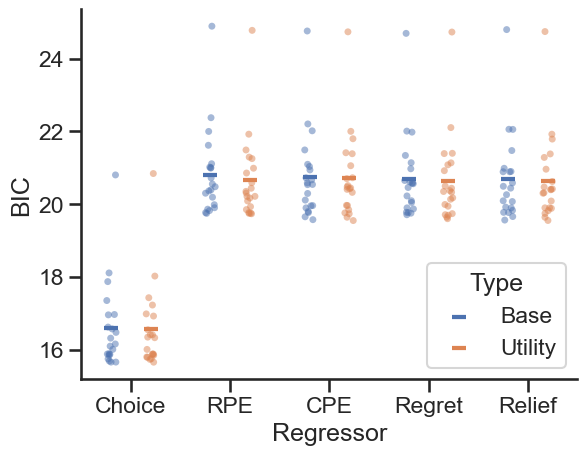

In [29]:
sns.stripplot(
    data=base_util_plot_data,  x="Regressor", y="BIC", hue='Type',
    dodge=True, alpha=.5, legend=False)
sns.pointplot(
    data=base_util_plot_data, x="Regressor", y="BIC", hue='Type',
    dodge=.4, linestyles='none',errorbar=None,
    markers="_")
sns.despine()

plt.savefig(f'{fig_dir}glm_bic_util_comp_{date}.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

In [30]:
base_util_plot_data

Model Regressor        BIC     Type
0           Base    Choice  16.152935     Base
0           Base    Choice  17.868648     Base
0           Base    Choice  16.313056     Base
0           Base    Choice  16.953757     Base
0           Base    Choice  16.004281     Base
..           ...       ...        ...      ...
0   dRelief_util    Relief  21.922884  Utility
0   dRelief_util    Relief  20.309987  Utility
0   dRelief_util    Relief  24.746440  Utility
0   dRelief_util    Relief  20.394723  Utility
0   dRelief_util    Relief  20.621921  Utility

[210 rows x 4 columns]

In [53]:
base_util_plot_data

Model Regressor        BIC     Type
0           Base    Choice  16.152935     Base
0           Base    Choice  17.868648     Base
0           Base    Choice  16.313056     Base
0           Base    Choice  16.953757     Base
0           Base    Choice  16.004281     Base
..           ...       ...        ...      ...
0   dRelief_util    Relief  21.922884  Utility
0   dRelief_util    Relief  20.309987  Utility
0   dRelief_util    Relief  24.746440  Utility
0   dRelief_util    Relief  20.394723  Utility
0   dRelief_util    Relief  20.621921  Utility

[210 rows x 4 columns]

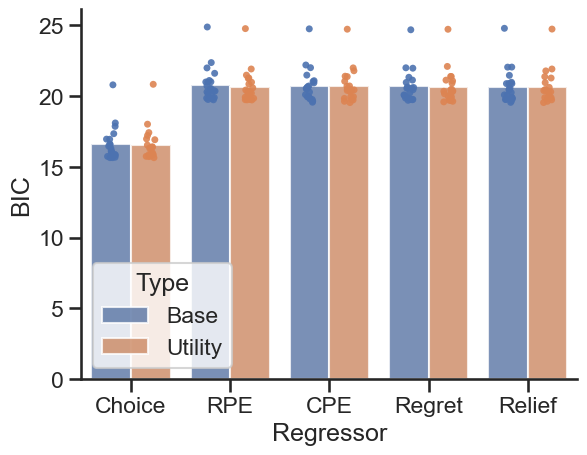

In [31]:
sns.stripplot(
    data=base_util_plot_data,  x="Regressor", y="BIC", hue='Type',
    dodge=True, alpha=0.9, legend=False)

sns.barplot(
    data=base_util_plot_data, x="Regressor", y="BIC", hue='Type',alpha=0.8,errorbar=None)#errwidth=0)

sns.despine() 

plt.savefig(f'{fig_dir}glm_bic_util_bars_{date}.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 


## Best 10 Model BIC Comparison Results
- Top 10 performing models with the lowest BICs selected


In [32]:
# top 10 model names for plotting

top10_models_list = ['Base_util',
                        'Base',
                        'dRegret_util',
                        'dRelief_util',
                        'RPE_util',
                        'pRPE',
                        'dRelief',
                        'dRegret',
                        'dCPE_util',
                        'dCPE']

In [33]:
# make base vs util bic comparison dfs
    # all subj BIC data for each model from all_results_dict
    # df with cols x = regressor name, y = BIC, color = util vs base 

# list of model names for comparison (selected from lowest BIC for each param) - grouped into tuples by regressor type

top10_plot_regressor_cats = ['Utility','EV','Regret Util','Relief Util','RPE Util','pRPE','Relief','Regret','CPE Util','CPE']


In [34]:
# iterate through plot models list - 

top10_plot_dict = {} # should contain reg cat, color cat, 
top10_plot_data = pd.DataFrame(columns=['Model','Regressor','BIC']) 
# base_util_plot_data = pd.DataFrame(columns=['Model','Regressor','Beta','Type']) 

for ix,name in enumerate(top10_models_list):
    #regressor name is same for model
    reg_name = top10_plot_regressor_cats[ix]
    #model var info - name, category for color
    # full_reg_name = models_dict[name][-1]
    # w_reg = all_results_dict[name][full_reg_name]
    # model_plot_dict = {'Regressor':[reg_name]*len(w_reg),'Type':[color]*len(w_reg),
    #                         'Model':[name]*len(w_reg),'Beta':w_reg}
    bic   = all_results_dict[name].bic
    top10_model_plot_dict = {'Regressor':[reg_name]*len(bic),
                                    'Model':[name]*len(bic),'BIC':bic}
    top10_plot_dict[name] = top10_model_plot_dict
    top10_plot_data = pd.concat([top10_plot_data,pd.DataFrame(top10_model_plot_dict)])

In [55]:
top10_plot_data

Model Regressor        BIC
0   Base_util   Utility  15.794284
0   Base_util   Utility  17.223868
0   Base_util   Utility  16.341217
0   Base_util   Utility  16.980526
0   Base_util   Utility  16.003626
..        ...       ...        ...
0        dCPE       CPE  22.016707
0        dCPE       CPE  20.540560
0        dCPE       CPE  24.762158
0        dCPE       CPE  20.940992
0        dCPE       CPE  21.034584

[210 rows x 3 columns]

In [56]:
top10_plot_data.groupby(['Regressor'])['BIC'].describe()

count       mean       std        min        25%        50%  \
Regressor                                                                  
CPE           21.0  20.742725  1.178963  19.572473  19.952405  20.540560   
CPE Util      21.0  20.707127  1.158991  19.547819  19.961935  20.445015   
EV            21.0  16.593545  1.199710  15.654698  15.864871  16.152935   
RPE Util      21.0  20.653286  1.138021  19.734751  19.930629  20.304403   
Regret        21.0  20.700252  1.142041  19.707939  19.896823  20.560316   
Regret Util   21.0  20.636173  1.160022  19.599089  19.942577  20.347368   
Relief        21.0  20.685069  1.193688  19.561264  19.896625  20.439538   
Relief Util   21.0  20.643944  1.161036  19.549904  19.897880  20.394723   
Utility       21.0  16.552999  1.176957  15.651874  15.842129  16.325108   
pRPE          21.0  20.663255  1.241538  19.600738  19.908100  20.179196   

                   75%        max  
Regressor                          
CPE          21.034584  24.762158  
CPE Util     21.056248  24.738729  
EV           16.953757  20.802516  
RPE Util     20.987500  24.779502  
Regret       20.972027  24.696882  
Regret Util  21.080974  24.733074  
Relief       20.897390  24.800658  
Relief Util  20.960564  24.746440  
Utility      16.920627  20.841221  
pRPE         20.928998  25.016240

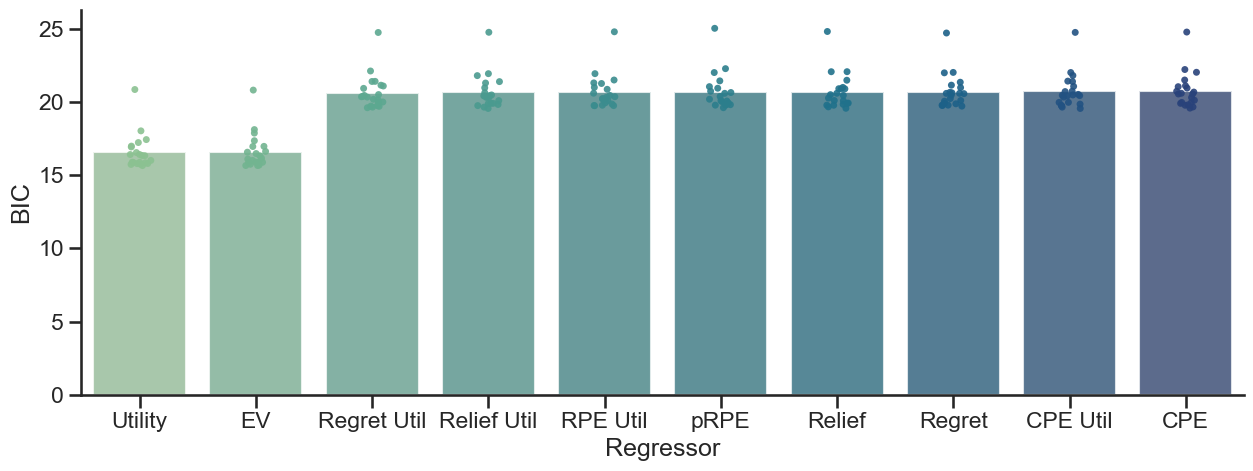

In [35]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.stripplot(ax=ax,
    data=top10_plot_data,  x="Regressor", y="BIC", palette='crest', #flare
    alpha=0.9, legend=False)

sns.barplot(ax=ax,
    data=top10_plot_data, x="Regressor", y="BIC",palette='crest',alpha=0.8,errorbar=None)#errwidth=0)

sns.despine() 

plt.savefig(f'{fig_dir}glm_bic_util_bars_{date}.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

## BDI Results

In [36]:
bdi_list = pd.read_excel(f'{base_dir}SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)

In [37]:
subj_bdis = list(zip(subj_ids,bdi_list))

In [38]:
subj_bdis

[('DA8', 13),
 ('DA9', 32),
 ('DA10', 11),
 ('DA11', 41),
 ('DA023', 14),
 ('DA026', 19),
 ('MS002', 14),
 ('MS003', 8),
 ('MS004', 7),
 ('MS016', 10),
 ('MS017', 26),
 ('MS019', 12),
 ('MS020', 6),
 ('MS022', 10),
 ('MS025', 10),
 ('MS026', 9),
 ('MS027', 22),
 ('MS029', 32),
 ('MS030', 19),
 ('MS033', 39),
 ('MS035', 15)]

In [71]:
np.array(bdi_list)

array([13, 32, 11, 41, 14, 19, 14,  8,  7, 10, 26, 12,  6, 10, 10,  9, 22,
       32, 19, 39, 15])

In [72]:
subj_bdi_cat[np.where(np.array(bdi_list)>=20)] = 1

In [73]:
subj_bdi_cat

array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0])

In [103]:
# bdi_weights_plot_models_list = [('RPE_dCPE','dCPE_RPE_util'),
#                               ('nRPE_dReg_pRPE_dRel','nRPE_pRPE_dReg_dRel_util')]

bdi_weights_models_list = ['RPE_dCPE','dCPE_RPE_util','nRPE_dReg_pRPE_dRel','nRPE_dReg_pRPE_dRel_util']

bdi_weights_plot_nparams = [4,4,6,6]
bdi_weights_plot_regressor_cats = [['CR','EV','RPE','CPE'],['Util Safe','Util Gamble','Util RPE','Util CPE'],
                                   ['CR','EV','nRPE','Regret','pRPE','Relief'],
                                   ['Util Safe','Util Gamble','Util nRPE','Util Regret','Util pRPE','Util Relief']]
bdi_weights_plot_type_cats = ['Base','Utility','Base','Utility']
# bdi_weights_plot_color_cats = ['High BDI','Low BDI']

subj_bdi_cat = np.array(bdi_list)
subj_bdi_cat[np.where(subj_bdi_cat<20)] = 0 # make sure this is first
subj_bdi_cat[np.where(subj_bdi_cat>=20)] = 1


bdi_weights_plot_dict = {} # should contain reg cat, color cat, 
bdi_weights_plot_data = pd.DataFrame(columns=['Model','Regressor','Var_ID','Type','Beta','BDI']) 

for ix,name in enumerate(bdi_weights_models_list):

    # model_name_list      = []
    # model_regressor_list = []
    # model_cols_list      = []
    # model_betas_list     = []
    # model_types_list     = []
    # model_bdis_list      = []

    fit_df = all_results_dict[name]
    col_names = fit_df.columns[-1*bdi_weights_plot_nparams[ix]:] #get column names from df
    weights = fit_df.loc[:,col_names]
    
    len_df = len(fit_df)*len(col_names)
    model_name_list      = [name]*len_df
    
    model_types_list = [bdi_weights_plot_type_cats[ix]]*len_df
    model_bdis_list = list(subj_bdi_cat)*len(col_names)
    


    model_betas_list = []
    model_regressor_list = []
    model_cols_list = []
    
    reg_names = bdi_weights_plot_regressor_cats[ix]
    # model_regressor_list = [reg_names[ir]]*len_df
    for ir,col in enumerate(col_names):
        
        model_betas_list     = model_betas_list +list(weights[col])
        reg_list             = [reg_names[ir]]*len(fit_df)
        model_regressor_list = model_regressor_list + reg_list
        cols_list            = [col]*len(fit_df)
        model_cols_list      = model_cols_list + cols_list


        
    model_bdi_dict = {'Model':model_name_list,'Regressor':model_regressor_list,'Var_ID':model_cols_list,
                                 'Type':model_types_list,'Beta':model_betas_list,'BDI':model_bdis_list}
    

    bdi_weights_plot_data = pd.concat([bdi_weights_plot_data,pd.DataFrame(model_bdi_dict)])
    bdi_weights_plot_dict[name] = model_bdi_dict
    # base_util_plot_data = pd.concat([base_util_plot_data,pd.DataFrame(model_plot_dict)])

In [104]:
bdi_weights_plot_data.groupby(['Regressor','BDI'])['Beta'].describe()

count      mean       std       min       25%       50%  \
Regressor   BDI                                                            
CPE         0     15.0  0.039219  0.254261 -0.437676 -0.058938  0.021931   
            1      6.0  0.181726  0.243153 -0.151229  0.040810  0.205611   
CR          0     30.0  0.161726  1.145791 -5.290150 -0.075464  0.378896   
            1     12.0  0.042665  1.048752 -1.719009 -0.533609  0.248388   
EV          0     30.0  0.411001  0.304682 -0.404930  0.253735  0.370913   
            1     12.0  0.515843  0.256489 -0.150812  0.459217  0.575180   
RPE         0     15.0  0.497902  0.324280 -0.183632  0.338360  0.514573   
            1      6.0  0.231780  0.260005 -0.242822  0.187011  0.312821   
Regret      0     15.0  0.007314  0.425516 -1.170299 -0.074694  0.122395   
            1      6.0  0.483208  0.197394  0.326169  0.344160  0.383052   
Relief      0     15.0  0.050919  0.378518 -0.444263 -0.122520 -0.058223   
            1      6.0  0.017215  0.338621 -0.476196 -0.146838  0.003884   
Util CPE    0     15.0  0.510851  1.169981 -0.338385  0.026628  0.176770   
            1      6.0  0.518998  0.543414 -0.411684  0.333757  0.599422   
Util Gamble 0     30.0 -0.092392  1.270862 -4.591852 -0.229746  0.255257   
            1     12.0  0.218832  0.573907 -0.531975 -0.227174 -0.006616   
Util RPE    0     15.0  0.154573  0.986355 -3.193489  0.143188  0.426442   
            1      6.0  0.114034  0.235235 -0.182425 -0.064850  0.144823   
Util Regret 0     15.0  0.479303  1.497172 -0.880656 -0.104126  0.152840   
            1      6.0  0.520242  1.021573 -1.225399  0.124260  0.789226   
Util Relief 0     15.0  0.490828  1.088664 -0.246663 -0.017918  0.144775   
            1      6.0  0.418862  0.681303 -0.176935 -0.066095  0.186849   
Util Safe   0     30.0  0.733088  2.070843 -0.616247 -0.208129  0.135677   
            1     12.0  0.251729  0.827413 -1.438660 -0.120203  0.360281   
Util nRPE   0     15.0  0.230312  1.197946 -3.609805 -0.033733  0.456447   
            1      6.0  0.060361  0.534762 -0.822084 -0.155238  0.127457   
Util pRPE   0     15.0  1.549506  3.322382 -0.225882  0.226812  0.507342   
            1      6.0  0.444442  0.781822 -0.993890  0.430323  0.572865   
nRPE        0     15.0  0.591221  0.622318 -0.358863  0.119831  0.516907   
            1      6.0  0.178548  0.243279 -0.062714  0.008105  0.155193   
pRPE        0     15.0  0.391551  0.359236 -0.362747  0.153411  0.439293   
            1      6.0  0.234950  0.483510 -0.438982 -0.094886  0.386369   

                      75%        max  
Regressor   BDI                       
CPE         0    0.082441   0.800183  
            1    0.276235   0.544710  
CR          0    0.639412   1.533287  
            1    0.978516   1.119741  
EV          0    0.622657   1.004415  
            1    0.675454   0.804354  
RPE         0    0.749108   0.982842  
            1    0.338331   0.515951  
Regret      0    0.285063   0.377758  
            1    0.634156   0.757919  
Relief      0    0.089147   1.180687  
            1    0.223526   0.472058  
Util CPE    0    0.292465   4.426514  
            1    0.894198   1.089168  
Util Gamble 0    0.458037   0.845152  
            1    0.660558   1.273363  
Util RPE    0    0.531804   0.940861  
            1    0.236923   0.444103  
Util Regret 0    0.317235   5.635970  
            1    1.211767   1.513176  
Util Relief 0    0.271685   3.828203  
            1    0.703195   1.591508  
Util Safe   0    0.643589   8.329535  
            1    0.799026   1.353189  
Util nRPE   0    0.926051   1.532292  
            1    0.409687   0.675043  
Util pRPE   0    0.628190  12.282226  
            1    0.716958   1.367015  
nRPE        0    1.014363   1.886518  
            1    0.229016   0.610916  
pRPE        0    0.546791   1.219688  
            1    0.459465   0.847415

In [105]:
bdi_weights_plot_data

Model    Regressor              Var_ID     Type  \
0                    RPE_dCPE           CR                  CR     Base   
1                    RPE_dCPE           CR                  CR     Base   
2                    RPE_dCPE           CR                  CR     Base   
3                    RPE_dCPE           CR                  CR     Base   
4                    RPE_dCPE           CR                  CR     Base   
..                        ...          ...                 ...      ...   
121  nRPE_dReg_pRPE_dRel_util  Util Relief  util_dRelief_emmap  Utility   
122  nRPE_dReg_pRPE_dRel_util  Util Relief  util_dRelief_emmap  Utility   
123  nRPE_dReg_pRPE_dRel_util  Util Relief  util_dRelief_emmap  Utility   
124  nRPE_dReg_pRPE_dRel_util  Util Relief  util_dRelief_emmap  Utility   
125  nRPE_dReg_pRPE_dRel_util  Util Relief  util_dRelief_emmap  Utility   

         Beta BDI  
0   -0.625048   0  
1   -0.463470   1  
2    1.065759   0  
3    0.783150   1  
4    0.430743   0  
..        ...  ..  
121 -0.112018   1  
122 -0.176935   1  
123 -0.145825   0  
124  0.302023   1  
125  2.160494   0  

[420 rows x 6 columns]

In [106]:
np.unique(bdi_weights_plot_data.Model)

array(['RPE_dCPE', 'dCPE_RPE_util', 'nRPE_dReg_pRPE_dRel',
       'nRPE_dReg_pRPE_dRel_util'], dtype=object)

### BDI x Regret/Relief & nRPE/pRPE

In [114]:
bdi_full_base_data = bdi_weights_plot_data[bdi_weights_plot_data.Model=='nRPE_dReg_pRPE_dRel']
bdi_full_base_data.BDI[bdi_full_base_data.BDI==1] = 'High'
bdi_full_base_data.BDI[bdi_full_base_data.BDI==0] = 'Low'
bdi_full_util_data = bdi_weights_plot_data[bdi_weights_plot_data.Model=='nRPE_dReg_pRPE_dRel_util']
bdi_full_util_data.BDI[bdi_full_util_data.BDI==1] = 'High'
bdi_full_util_data.BDI[bdi_full_util_data.BDI==0] = 'Low'

/var/folders/xk/q5rxx0ld0hnc9gjlq1dhwqhw0000gn/T/ipykernel_14744/226023734.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdi_full_base_data.BDI[bdi_full_base_data.BDI==1] = 'High'
/var/folders/xk/q5rxx0ld0hnc9gjlq1dhwqhw0000gn/T/ipykernel_14744/226023734.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdi_full_base_data.BDI[bdi_full_base_data.BDI==1] = 'High'
/var/folders/xk/q5rxx0ld0hnc9gjlq1dhwqhw0000gn/T/ipykernel_14744/226023734.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

In [115]:
bdi_full_base_data

Model Regressor          Var_ID  Type      Beta   BDI
0    nRPE_dReg_pRPE_dRel        CR              CR  Base -0.546326   Low
1    nRPE_dReg_pRPE_dRel        CR              CR  Base -0.744024  High
2    nRPE_dReg_pRPE_dRel        CR              CR  Base  1.039892   Low
3    nRPE_dReg_pRPE_dRel        CR              CR  Base  0.744590  High
4    nRPE_dReg_pRPE_dRel        CR              CR  Base  0.113914   Low
..                   ...       ...             ...   ...       ...   ...
121  nRPE_dReg_pRPE_dRel    Relief  decisionRelief  Base -0.476196  High
122  nRPE_dReg_pRPE_dRel    Relief  decisionRelief  Base  0.248847  High
123  nRPE_dReg_pRPE_dRel    Relief  decisionRelief  Base  0.059593   Low
124  nRPE_dReg_pRPE_dRel    Relief  decisionRelief  Base -0.139796  High
125  nRPE_dReg_pRPE_dRel    Relief  decisionRelief  Base  1.180687   Low

[126 rows x 6 columns]

In [116]:
bdi_full_base_data.groupby(['Regressor','BDI'])['Beta'].describe()

count      mean       std       min       25%       50%  \
Regressor BDI                                                             
CR        High    6.0  0.012525  1.127648 -1.719009 -0.633382  0.221566   
          Low    15.0  0.352517  0.528562 -0.546326 -0.072860  0.351095   
EV        High    6.0  0.534741  0.164546  0.241625  0.487738  0.573866   
          Low    15.0  0.400400  0.357435 -0.404930  0.257350  0.358518   
Regret    High    6.0  0.483208  0.197394  0.326169  0.344160  0.383052   
          Low    15.0  0.007314  0.425516 -1.170299 -0.074694  0.122395   
Relief    High    6.0  0.017215  0.338621 -0.476196 -0.146838  0.003884   
          Low    15.0  0.050919  0.378518 -0.444263 -0.122520 -0.058223   
nRPE      High    6.0  0.178548  0.243279 -0.062714  0.008105  0.155193   
          Low    15.0  0.591221  0.622318 -0.358863  0.119831  0.516907   
pRPE      High    6.0  0.234950  0.483510 -0.438982 -0.094886  0.386369   
          Low    15.0  0.391551  0.359236 -0.362747  0.153411  0.439293   

                     75%       max  
Regressor BDI                       
CR        High  0.917627  1.119741  
          Low   0.625981  1.533287  
EV        High  0.651692  0.682424  
          Low   0.637932  1.004415  
Regret    High  0.634156  0.757919  
          Low   0.285063  0.377758  
Relief    High  0.223526  0.472058  
          Low   0.089147  1.180687  
nRPE      High  0.229016  0.610916  
          Low   1.014363  1.886518  
pRPE      High  0.459465  0.847415  
          Low   0.546791  1.219688

In [128]:
np.unique(bdi_full_base_data.Var_ID)

array(['CR', 'choiceEV', 'decisionRegret', 'decisionRelief', 'nRPE',
       'pRPE'], dtype=object)

In [129]:
# Quick Stats - 
params_to_test = ['CR', 'choiceEV', 'decisionRegret', 'decisionRelief', 'nRPE', 'pRPE']

bdi_full_base_stats = {}
for param in params_to_test:
    dep = bdi_full_base_data.loc[(bdi_full_base_data.Var_ID == param)&(bdi_full_base_data.BDI == "High"), "Beta"].values
    ndep = bdi_full_base_data.loc[(bdi_full_base_data.Var_ID == param)&(bdi_full_base_data.BDI == "Low"), "Beta"].values
    _,p = mannwhitneyu(dep, ndep, alternative="two-sided")
    bdi_full_base_stats[param] = p

bdi_full_base_stats


{'CR': 0.7909848149786229,
 'choiceEV': 0.42433289105115735,
 'decisionRegret': 0.0016217013121037887,
 'decisionRelief': 0.9698510983340705,
 'nRPE': 0.15369305616983636,
 'pRPE': 0.5186864219371959}

### Plot bdi_full_base_data

In [138]:
bdi_full_base_stats.keys()

dict_keys(['CR', 'choiceEV', 'decisionRegret', 'decisionRelief', 'nRPE', 'pRPE'])

In [141]:
plot_data

Model Regressor Var_ID  Type      Beta   BDI
84   nRPE_dReg_pRPE_dRel      pRPE   pRPE  Base  0.429566   Low
85   nRPE_dReg_pRPE_dRel      pRPE   pRPE  Base  0.847415  High
86   nRPE_dReg_pRPE_dRel      pRPE   pRPE  Base  0.627458   Low
87   nRPE_dReg_pRPE_dRel      pRPE   pRPE  Base  0.477516  High
88   nRPE_dReg_pRPE_dRel      pRPE   pRPE  Base  0.373674   Low
89   nRPE_dReg_pRPE_dRel      pRPE   pRPE  Base  0.017033   Low
90   nRPE_dReg_pRPE_dRel      pRPE   pRPE  Base  0.191584   Low
91   nRPE_dReg_pRPE_dRel      pRPE   pRPE  Base  0.503948   Low
92   nRPE_dReg_pRPE_dRel      pRPE   pRPE  Base  0.589635   Low
93   nRPE_dReg_pRPE_dRel      pRPE   pRPE  Base  0.115238   Low
94   nRPE_dReg_pRPE_dRel      pRPE   pRPE  Base -0.248990  High
95   nRPE_dReg_pRPE_dRel      pRPE   pRPE  Base  0.705073   Low
96   nRPE_dReg_pRPE_dRel      pRPE   pRPE  Base  0.469373   Low
97   nRPE_dReg_pRPE_dRel      pRPE   pRPE  Base  0.114018   Low
98   nRPE_dReg_pRPE_dRel      pRPE   pRPE  Base  0.439293   Low
99   nRPE_dReg_pRPE_dRel      pRPE   pRPE  Base  1.219688   Low
100  nRPE_dReg_pRPE_dRel      pRPE   pRPE  Base  0.405313  High
101  nRPE_dReg_pRPE_dRel      pRPE   pRPE  Base -0.438982  High
102  nRPE_dReg_pRPE_dRel      pRPE   pRPE  Base -0.362747   Low
103  nRPE_dReg_pRPE_dRel      pRPE   pRPE  Base  0.367426  High
104  nRPE_dReg_pRPE_dRel      pRPE   pRPE  Base  0.440433   Low

In [214]:
bdi_full_base_data

Model Regressor          Var_ID  Type      Beta   BDI
0    nRPE_dReg_pRPE_dRel        CR              CR  Base -0.546326   Low
1    nRPE_dReg_pRPE_dRel        CR              CR  Base -0.744024  High
2    nRPE_dReg_pRPE_dRel        CR              CR  Base  1.039892   Low
3    nRPE_dReg_pRPE_dRel        CR              CR  Base  0.744590  High
4    nRPE_dReg_pRPE_dRel        CR              CR  Base  0.113914   Low
..                   ...       ...             ...   ...       ...   ...
121  nRPE_dReg_pRPE_dRel    Relief  decisionRelief  Base -0.476196  High
122  nRPE_dReg_pRPE_dRel    Relief  decisionRelief  Base  0.248847  High
123  nRPE_dReg_pRPE_dRel    Relief  decisionRelief  Base  0.059593   Low
124  nRPE_dReg_pRPE_dRel    Relief  decisionRelief  Base -0.139796  High
125  nRPE_dReg_pRPE_dRel    Relief  decisionRelief  Base  1.180687   Low

[126 rows x 6 columns]

In [217]:
model_id = bdi_full_base_data.Model[0]
model_id

'nRPE_dReg_pRPE_dRel'

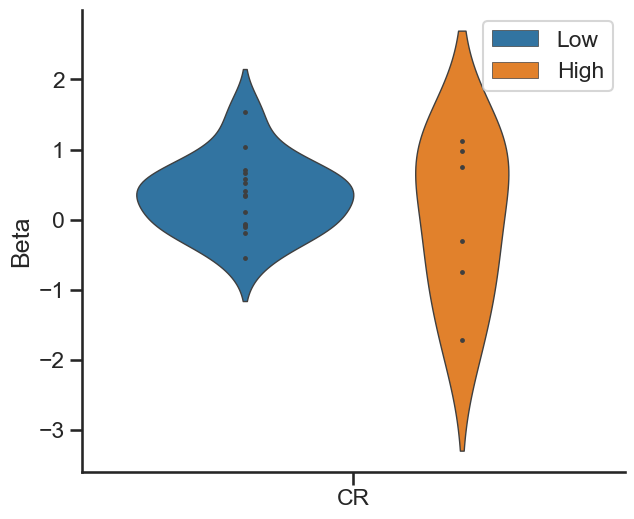

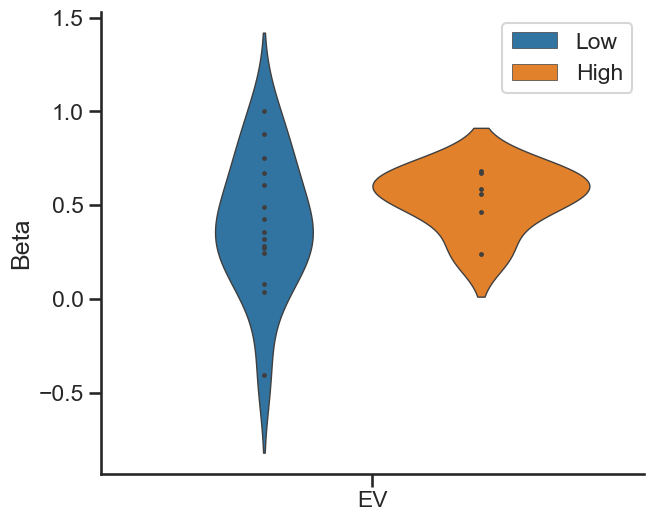

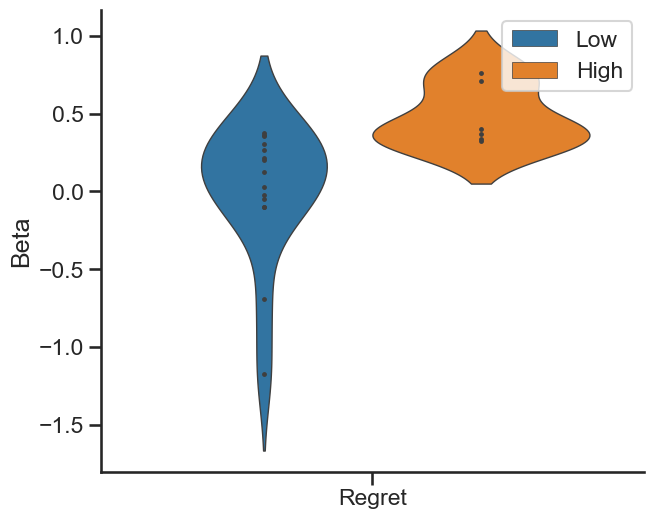

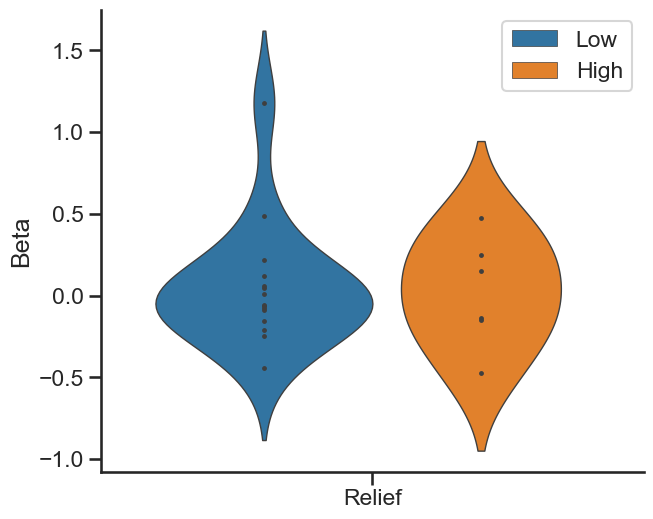

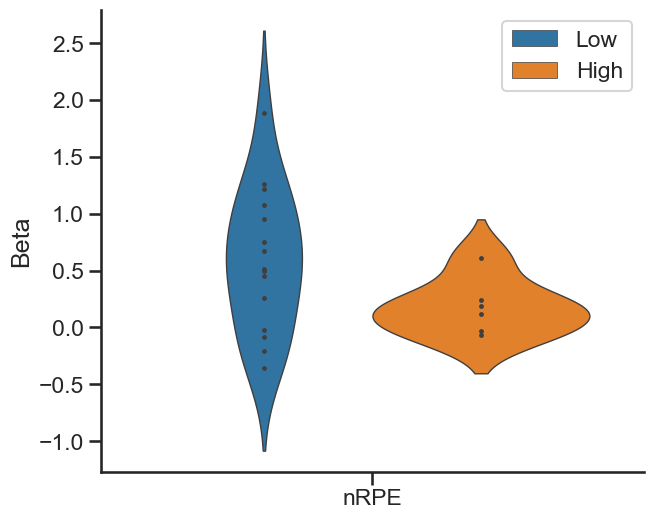

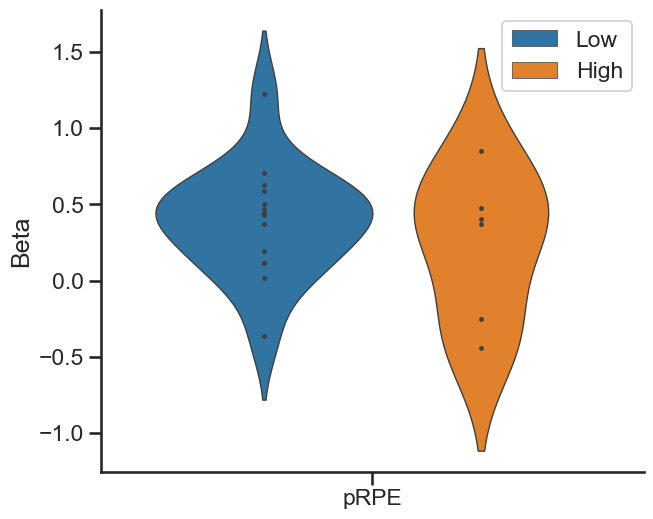

In [218]:
plot_vars = ['CR', 'choiceEV', 'decisionRegret', 'decisionRelief', 'nRPE', 'pRPE']

for var in plot_vars:

    model_id = model_id = bdi_full_base_data.Model[0]
    plot_data = bdi_full_base_data[(bdi_full_base_data.Var_ID == var)]

    fig, ax = plt.subplots(figsize=(7, 6))

    sns.violinplot(ax=ax,
        data=plot_data, x='Regressor', y="Beta", hue='BDI',palette='tab10',
        scale='area',split=False,linewidth=1,legend=False,inner='point')#errwidth=0)
    ax.legend()
    ax.set(xlabel=None)

    
    sns.despine() 


    plt.savefig(f'{fig_dir}{model_id}_{var}_bdi_betas_{date}.pdf', dpi=500, format='pdf', metadata=None,
    bbox_inches='tight', pad_inches=0.2,
    facecolor='auto', edgecolor='auto',
    backend=None) 

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))


sns.violinplot(ax=ax,
    data=cpe_vars, x="Regressor", y="Beta", hue='BDI',native_scale=False,
    density_norm='width',split=False,linewidth=1)#errwidth=0)


sns.despine() 



# plt.savefig(f'{fig_dir}glm_bic_util_bars_{date}.pdf', dpi=500, format='pdf', metadata=None,
# bbox_inches='tight', pad_inches=0.2,
# facecolor='auto', edgecolor='auto',
# backend=None) 

In [ ]:


sns.boxplot(data=cpe_vars, x='Regressor',y='Beta', hue='BDI',palette='Oranges_r')


In [117]:
bdi_full_util_data

Model    Regressor              Var_ID     Type  \
0    nRPE_dReg_pRPE_dRel_util    Util Safe     util_safe_emmap  Utility   
1    nRPE_dReg_pRPE_dRel_util    Util Safe     util_safe_emmap  Utility   
2    nRPE_dReg_pRPE_dRel_util    Util Safe     util_safe_emmap  Utility   
3    nRPE_dReg_pRPE_dRel_util    Util Safe     util_safe_emmap  Utility   
4    nRPE_dReg_pRPE_dRel_util    Util Safe     util_safe_emmap  Utility   
..                        ...          ...                 ...      ...   
121  nRPE_dReg_pRPE_dRel_util  Util Relief  util_dRelief_emmap  Utility   
122  nRPE_dReg_pRPE_dRel_util  Util Relief  util_dRelief_emmap  Utility   
123  nRPE_dReg_pRPE_dRel_util  Util Relief  util_dRelief_emmap  Utility   
124  nRPE_dReg_pRPE_dRel_util  Util Relief  util_dRelief_emmap  Utility   
125  nRPE_dReg_pRPE_dRel_util  Util Relief  util_dRelief_emmap  Utility   

         Beta   BDI  
0   -0.364626   Low  
1   -1.438660  High  
2    0.225528   Low  
3    0.005773  High  
4    0.035284   Low  
..        ...   ...  
121 -0.112018  High  
122 -0.176935  High  
123 -0.145825   Low  
124  0.302023  High  
125  2.160494   Low  

[126 rows x 6 columns]

In [119]:
bdi_full_util_data.groupby(['Var_ID','BDI'])['Beta'].describe()

count      mean       std       min       25%  \
Var_ID             BDI                                                   
util_dRegret_emmap High    6.0  0.520242  1.021573 -1.225399  0.124260   
                   Low    15.0  0.479303  1.497172 -0.880656 -0.104126   
util_dRelief_emmap High    6.0  0.418862  0.681303 -0.176935 -0.066095   
                   Low    15.0  0.490828  1.088664 -0.246663 -0.017918   
util_gamble_emmap  High    6.0  0.255566  0.661603 -0.324099 -0.229023   
                   Low    15.0 -0.137678  1.276997 -4.543877 -0.239102   
util_nRPE_emmap    High    6.0  0.060361  0.534762 -0.822084 -0.155238   
                   Low    15.0  0.230312  1.197946 -3.609805 -0.033733   
util_pRPE_emmap    High    6.0  0.444442  0.781822 -0.993890  0.430323   
                   Low    15.0  1.549506  3.322382 -0.225882  0.226812   
util_safe_emmap    High    6.0  0.234023  0.932646 -1.438660  0.027807   
                   Low    15.0  0.783256  2.147572 -0.364626 -0.211363   

                              50%       75%        max  
Var_ID             BDI                                  
util_dRegret_emmap High  0.789226  1.211767   1.513176  
                   Low   0.152840  0.317235   5.635970  
util_dRelief_emmap High  0.186849  0.703195   1.591508  
                   Low   0.144775  0.271685   3.828203  
util_gamble_emmap  High -0.006616  0.673739   1.273363  
                   Low   0.286168  0.384681   0.813208  
util_nRPE_emmap    High  0.127457  0.409687   0.675043  
                   Low   0.456447  0.926051   1.532292  
util_pRPE_emmap    High  0.572865  0.716958   1.367015  
                   Low   0.507342  0.628190  12.282226  
util_safe_emmap    High  0.413213  0.829312   1.149025  
                   Low   0.225528  0.681198   8.329535

In [135]:
# Quick Stats - 
params_to_test = ['util_safe_emmap','util_gamble_emmap','util_nRPE_emmap','util_dRegret_emmap','util_pRPE_emmap','util_dRelief_emmap']

bdi_full_util_stats = {}
for param in params_to_test:
    dep = bdi_full_util_data.loc[(bdi_full_util_data.Var_ID == param)&(bdi_full_util_data.BDI == "High"), "Beta"].values
    ndep = bdi_full_util_data.loc[(bdi_full_util_data.Var_ID == param)&(bdi_full_util_data.BDI == "Low"), "Beta"].values
    _,p = mannwhitneyu(dep, ndep, alternative="two-sided")
    bdi_full_util_stats[param] = p

bdi_full_util_stats

{'util_safe_emmap': 0.7333038478549314,
 'util_gamble_emmap': 0.9095901518502137,
 'util_nRPE_emmap': 0.3022998673153472,
 'util_dRegret_emmap': 0.34029927760577916,
 'util_pRPE_emmap': 0.7909848149786229,
 'util_dRelief_emmap': 0.8499926286303995}

In [219]:
bdi_full_util_data

Model    Regressor              Var_ID     Type  \
0    nRPE_dReg_pRPE_dRel_util    Util Safe     util_safe_emmap  Utility   
1    nRPE_dReg_pRPE_dRel_util    Util Safe     util_safe_emmap  Utility   
2    nRPE_dReg_pRPE_dRel_util    Util Safe     util_safe_emmap  Utility   
3    nRPE_dReg_pRPE_dRel_util    Util Safe     util_safe_emmap  Utility   
4    nRPE_dReg_pRPE_dRel_util    Util Safe     util_safe_emmap  Utility   
..                        ...          ...                 ...      ...   
121  nRPE_dReg_pRPE_dRel_util  Util Relief  util_dRelief_emmap  Utility   
122  nRPE_dReg_pRPE_dRel_util  Util Relief  util_dRelief_emmap  Utility   
123  nRPE_dReg_pRPE_dRel_util  Util Relief  util_dRelief_emmap  Utility   
124  nRPE_dReg_pRPE_dRel_util  Util Relief  util_dRelief_emmap  Utility   
125  nRPE_dReg_pRPE_dRel_util  Util Relief  util_dRelief_emmap  Utility   

         Beta   BDI  
0   -0.364626   Low  
1   -1.438660  High  
2    0.225528   Low  
3    0.005773  High  
4    0.035284   Low  
..        ...   ...  
121 -0.112018  High  
122 -0.176935  High  
123 -0.145825   Low  
124  0.302023  High  
125  2.160494   Low  

[126 rows x 6 columns]

In [220]:
np.unique(bdi_full_util_data.Var_ID)

array(['util_dRegret_emmap', 'util_dRelief_emmap', 'util_gamble_emmap',
       'util_nRPE_emmap', 'util_pRPE_emmap', 'util_safe_emmap'],
      dtype=object)

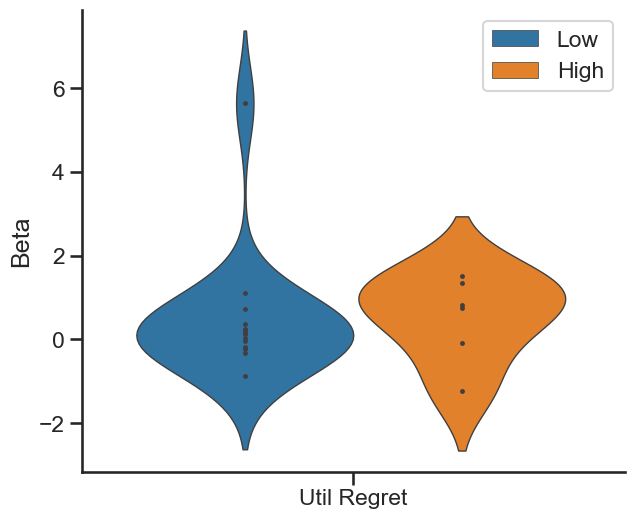

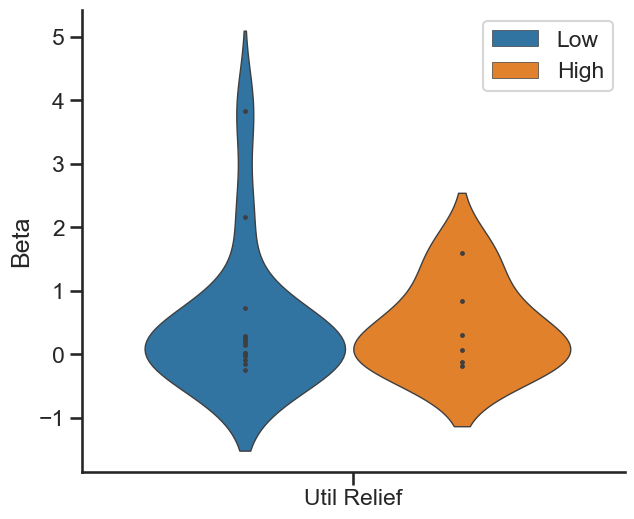

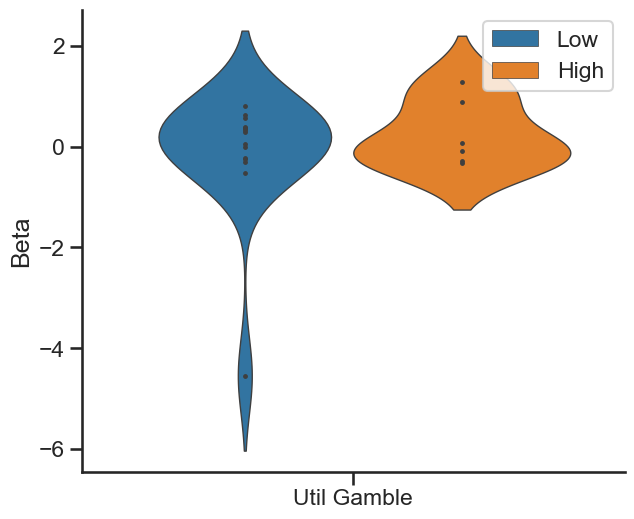

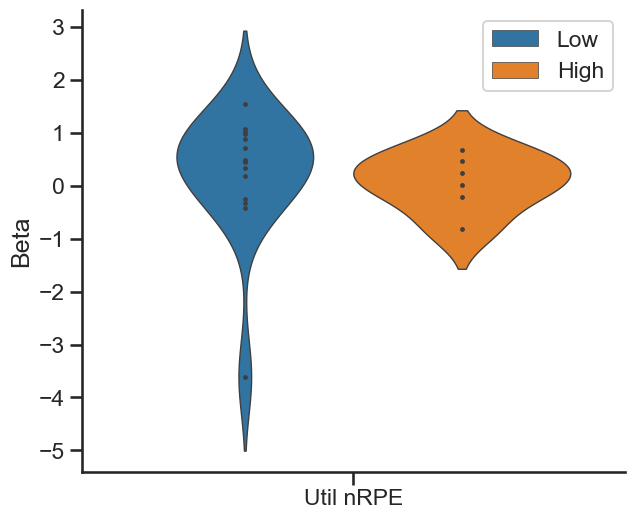

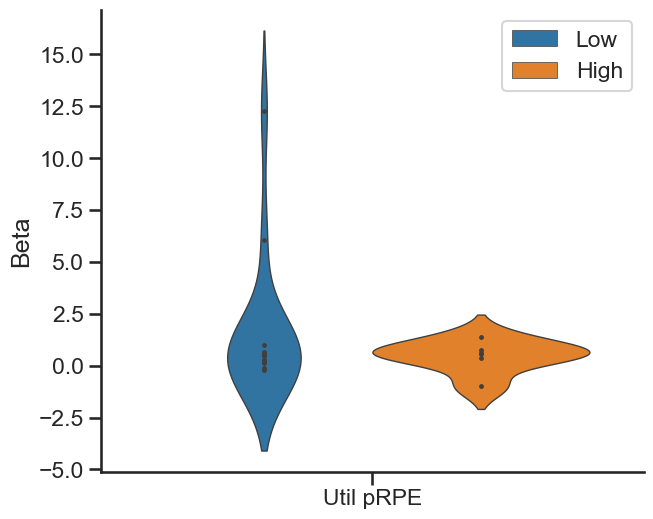

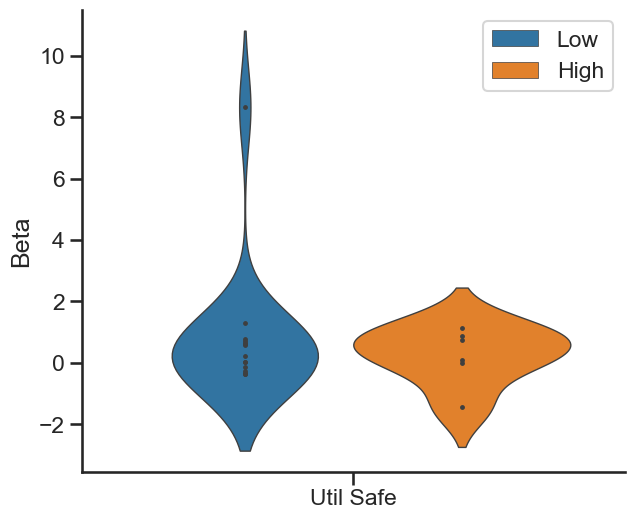

In [221]:
plot_vars = ['util_dRegret_emmap', 'util_dRelief_emmap', 'util_gamble_emmap',
       'util_nRPE_emmap', 'util_pRPE_emmap', 'util_safe_emmap']

for var in plot_vars:

    model_id = model_id = bdi_full_util_data.Model[0]
    plot_data = bdi_full_util_data[(bdi_full_util_data.Var_ID == var)]

    fig, ax = plt.subplots(figsize=(7, 6))

    sns.violinplot(ax=ax,
        data=plot_data, x='Regressor', y="Beta", hue='BDI',palette='tab10',
        scale='area',split=False,linewidth=1,legend=False,inner='point')#errwidth=0)
    ax.legend()
    ax.set(xlabel=None)

    
    sns.despine() 


    plt.savefig(f'{fig_dir}{model_id}_{var}_bdi_betas_{date}.pdf', dpi=500, format='pdf', metadata=None,
    bbox_inches='tight', pad_inches=0.2,
    facecolor='auto', edgecolor='auto',
    backend=None) 

In [ ]:
# from scipy.stats import mannwhitneyu, normaltest
# dep = cpe_vars.loc[(cpe_vars.BDI == "High"), "Beta"].values
# ndep = cpe_vars.loc[(cpe_vars.BDI == "Low"), "Beta"].values

# mannwhitneyu(dep, ndep, alternative="two-sided")
# stat_results = [
#   mannwhitneyu(robots, flight, alternative="two-sided"),
#   mannwhitneyu(flight, sound, alternative="two-sided"),
#   mannwhitneyu(robots, sound, alternative="two-sided")
# ]

# pvalues = [result.pvalue for result in stat_results]

# print("Robots vs Flight: \n", stat_results[0], "\n")
# print("Flight vs Sound: \n", stat_results[1], "\n")
# print("robots vs Sound: \n", stat_results[2], "\n")

## BDI x CPE & RPE

In [42]:
bdi_cpe_rpe_base_data = bdi_weights_plot_data[bdi_weights_plot_data.Model=='RPE_dCPE']
bdi_cpe_rpe_base_data.BDI[bdi_cpe_rpe_base_data.BDI==1] = 'High'
bdi_cpe_rpe_base_data.BDI[bdi_cpe_rpe_base_data.BDI==0] = 'Low'
bdi_cpe_rpe_util_data = bdi_weights_plot_data[bdi_weights_plot_data.Model=='dCPE_RPE_util']
bdi_cpe_rpe_util_data.BDI[bdi_cpe_rpe_util_data.BDI==1] = 'High'
bdi_cpe_rpe_util_data.BDI[bdi_cpe_rpe_util_data.BDI==0] = 'Low'

/var/folders/xk/q5rxx0ld0hnc9gjlq1dhwqhw0000gn/T/ipykernel_14744/536908058.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdi_cpe_rpe_base_data.BDI[bdi_cpe_rpe_base_data.BDI==1] = 'High'
/var/folders/xk/q5rxx0ld0hnc9gjlq1dhwqhw0000gn/T/ipykernel_14744/536908058.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdi_cpe_rpe_base_data.BDI[bdi_cpe_rpe_base_data.BDI==1] = 'High'
/var/folders/xk/q5rxx0ld0hnc9gjlq1dhwqhw0000gn/T/ipykernel_14744/536908058.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/panda

In [59]:
bdi_cpe_rpe_base_data

Model Regressor       Var_ID  Type      Beta   BDI
0   RPE_dCPE        CR           CR  Base -0.625048   Low
1   RPE_dCPE        CR           CR  Base -0.463470  High
2   RPE_dCPE        CR           CR  Base  1.065759   Low
3   RPE_dCPE        CR           CR  Base  0.783150  High
4   RPE_dCPE        CR           CR  Base  0.430743   Low
..       ...       ...          ...   ...       ...   ...
79  RPE_dCPE       CPE  decisionCPE  Base -0.151229  High
80  RPE_dCPE       CPE  decisionCPE  Base  0.299072  High
81  RPE_dCPE       CPE  decisionCPE  Base  0.027894   Low
82  RPE_dCPE       CPE  decisionCPE  Base -0.013420  High
83  RPE_dCPE       CPE  decisionCPE  Base  0.800183   Low

[84 rows x 6 columns]

In [60]:
bdi_cpe_rpe_base_data.groupby(['Regressor','BDI'])['Beta'].describe()

count      mean       std       min       25%       50%  \
Regressor BDI                                                             
CPE       High    6.0  0.181726  0.243153 -0.151229  0.040810  0.205611   
          Low    15.0  0.039219  0.254261 -0.437676 -0.058938  0.021931   
CR        High    6.0  0.072805  1.070498 -1.672010 -0.409556  0.267668   
          Low    15.0 -0.029066  1.536901 -5.290150 -0.081191  0.409512   
EV        High    6.0  0.496946  0.341757 -0.150812  0.475452  0.575568   
          Low    15.0  0.421601  0.253561 -0.025238  0.258238  0.383308   
RPE       High    6.0  0.231780  0.260005 -0.242822  0.187011  0.312821   
          Low    15.0  0.497902  0.324280 -0.183632  0.338360  0.514573   

                     75%       max  
Regressor BDI                       
CPE       High  0.276235  0.544710  
          Low   0.082441  0.800183  
CR        High  0.936896  1.048830  
          Low   0.544117  1.299887  
EV        High  0.695079  0.804354  
          Low   0.609935  0.897358  
RPE       High  0.338331  0.515951  
          Low   0.749108  0.982842

In [132]:
np.unique(bdi_cpe_rpe_base_data.Var_ID)

array(['CR', 'RPE', 'choiceEV', 'decisionCPE'], dtype=object)

In [134]:
# Quick Stats - 
params_to_test = ['CR', 'RPE', 'choiceEV', 'decisionCPE']

bdi_cpe_rpe_base_stats = {}
for param in params_to_test:
    dep = bdi_cpe_rpe_base_data.loc[(bdi_cpe_rpe_base_data.Var_ID == param)&(bdi_cpe_rpe_base_data.BDI == "High"), "Beta"].values
    ndep = bdi_cpe_rpe_base_data.loc[(bdi_cpe_rpe_base_data.Var_ID == param)&(bdi_cpe_rpe_base_data.BDI == "Low"), "Beta"].values
    _,p = mannwhitneyu(dep, ndep, alternative="two-sided")
    bdi_cpe_rpe_base_stats[param] = p

bdi_cpe_rpe_base_stats

{'CR': 0.9095901518502137,
 'RPE': 0.06630546955624356,
 'choiceEV': 0.47018280996609174,
 'decisionCPE': 0.20510835913312694}

In [222]:
np.unique(bdi_cpe_rpe_base_data.Var_ID)

array(['CR', 'RPE', 'choiceEV', 'decisionCPE'], dtype=object)

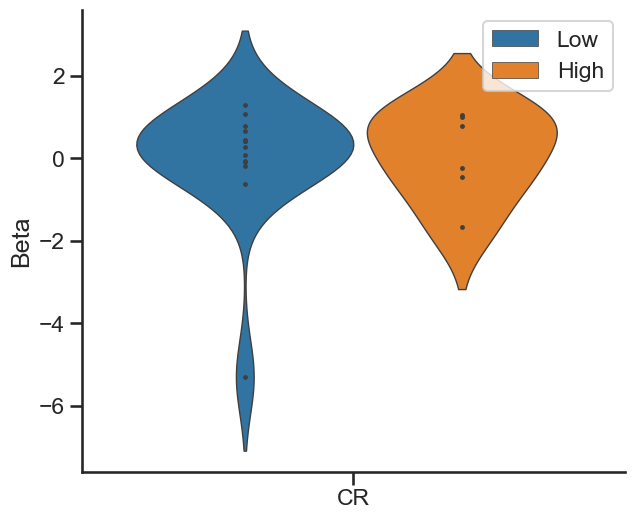

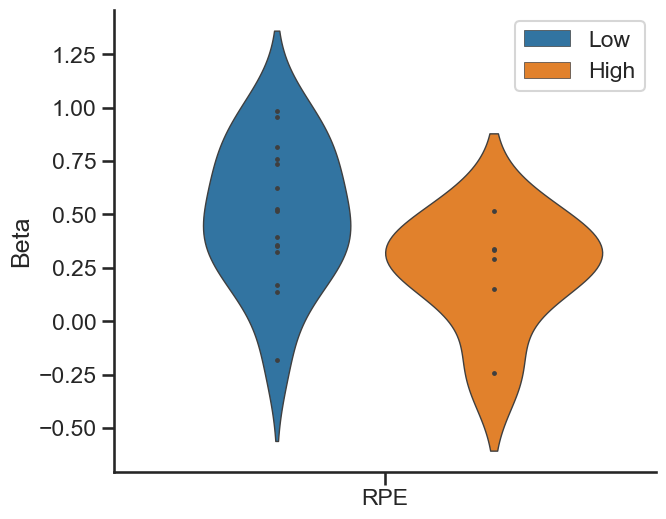

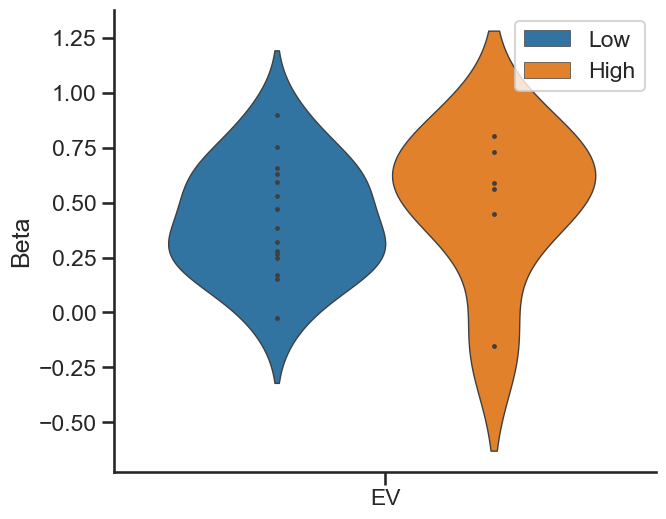

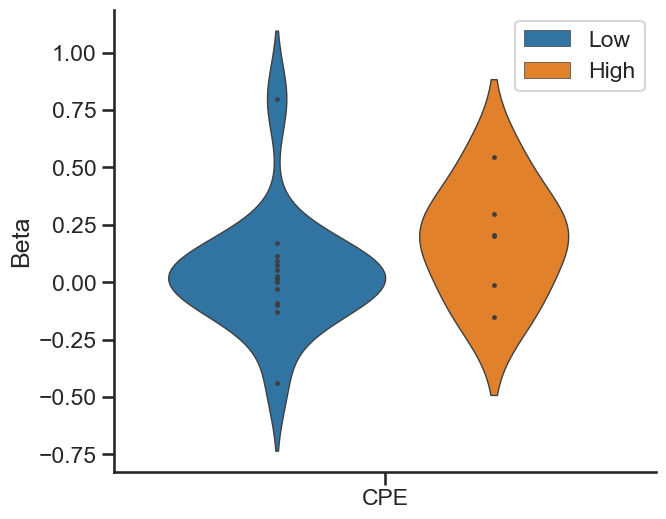

In [223]:
np.unique(bdi_cpe_rpe_base_data.Var_ID)
plot_vars = ['CR', 'RPE', 'choiceEV', 'decisionCPE']

for var in plot_vars:

    model_id = model_id = bdi_cpe_rpe_base_data.Model[0]
    plot_data = bdi_cpe_rpe_base_data[(bdi_cpe_rpe_base_data.Var_ID == var)]

    fig, ax = plt.subplots(figsize=(7, 6))

    sns.violinplot(ax=ax,
        data=plot_data, x='Regressor', y="Beta", hue='BDI',palette='tab10',
        scale='area',split=False,linewidth=1,legend=False,inner='point')#errwidth=0)
    ax.legend()
    ax.set(xlabel=None)

    
    sns.despine() 


    plt.savefig(f'{fig_dir}{model_id}_{var}_bdi_betas_{date}.pdf', dpi=500, format='pdf', metadata=None,
    bbox_inches='tight', pad_inches=0.2,
    facecolor='auto', edgecolor='auto',
    backend=None) 

In [43]:
bdi_cpe_rpe_util_data

Model  Regressor           Var_ID     Type      Beta   BDI
0   dCPE_RPE_util  Util Safe  util_safe_emmap  Utility -0.337017   Low
1   dCPE_RPE_util  Util Safe  util_safe_emmap  Utility -0.737182  High
2   dCPE_RPE_util  Util Safe  util_safe_emmap  Utility  0.069780   Low
3   dCPE_RPE_util  Util Safe  util_safe_emmap  Utility  0.109732  High
4   dCPE_RPE_util  Util Safe  util_safe_emmap  Utility -0.123387   Low
..            ...        ...              ...      ...       ...   ...
79  dCPE_RPE_util   Util CPE  util_dCPE_emmap  Utility -0.411684  High
80  dCPE_RPE_util   Util CPE  util_dCPE_emmap  Utility  0.275189  High
81  dCPE_RPE_util   Util CPE  util_dCPE_emmap  Utility  0.063669   Low
82  dCPE_RPE_util   Util CPE  util_dCPE_emmap  Utility  0.509461  High
83  dCPE_RPE_util   Util CPE  util_dCPE_emmap  Utility  1.627942   Low

[84 rows x 6 columns]

In [61]:
bdi_cpe_rpe_util_data.groupby(['Regressor','BDI'])['Beta'].describe()

count      mean       std       min       25%       50%  \
Regressor   BDI                                                             
Util CPE    High    6.0  0.518998  0.543414 -0.411684  0.333757  0.599422   
            Low    15.0  0.510851  1.169981 -0.338385  0.026628  0.176770   
Util Gamble High    6.0  0.182098  0.532592 -0.531975 -0.182334  0.214624   
            Low    15.0 -0.047106  1.307832 -4.591852 -0.045580  0.254021   
Util RPE    High    6.0  0.114034  0.235235 -0.182425 -0.064850  0.144823   
            Low    15.0  0.154573  0.986355 -3.193489  0.143188  0.426442   
Util Safe   High    6.0  0.269435  0.797224 -0.737182 -0.346167  0.360281   
            Low    15.0  0.682919  2.065341 -0.616247 -0.194266  0.082372   

                       75%       max  
Regressor   BDI                       
Util CPE    High  0.894198  1.089168  
            Low   0.292465  4.426514  
Util Gamble High  0.595445  0.787585  
            Low   0.504195  0.845152  
Util RPE    High  0.236923  0.444103  
            Low   0.531804  0.940861  
Util Safe   High  0.736340  1.353189  
            Low   0.528212  7.861627

In [136]:
np.unique(bdi_cpe_rpe_util_data.Var_ID)

array(['util_RPE_emmap', 'util_dCPE_emmap', 'util_gamble_emmap',
       'util_safe_emmap'], dtype=object)

In [137]:
# Quick Stats - 
params_to_test = ['util_RPE_emmap', 'util_dCPE_emmap', 'util_gamble_emmap',
       'util_safe_emmap']

bdi_cpe_rpe_util_stats = {}
for param in params_to_test:
    dep = bdi_cpe_rpe_util_data.loc[(bdi_cpe_rpe_util_data.Var_ID == param)&(bdi_cpe_rpe_util_data.BDI == "High"), "Beta"].values
    ndep = bdi_cpe_rpe_util_data.loc[(bdi_cpe_rpe_util_data.Var_ID == param)&(bdi_cpe_rpe_util_data.BDI == "Low"), "Beta"].values
    _,p = mannwhitneyu(dep, ndep, alternative="two-sided")
    bdi_cpe_rpe_util_stats[param] = p

bdi_cpe_rpe_util_stats

{'util_RPE_emmap': 0.15369305616983636,
 'util_dCPE_emmap': 0.2672121480171016,
 'util_gamble_emmap': 0.9698510983340705,
 'util_safe_emmap': 0.9095901518502137}

In [224]:
np.unique(bdi_cpe_rpe_util_data.Var_ID)

array(['util_RPE_emmap', 'util_dCPE_emmap', 'util_gamble_emmap',
       'util_safe_emmap'], dtype=object)

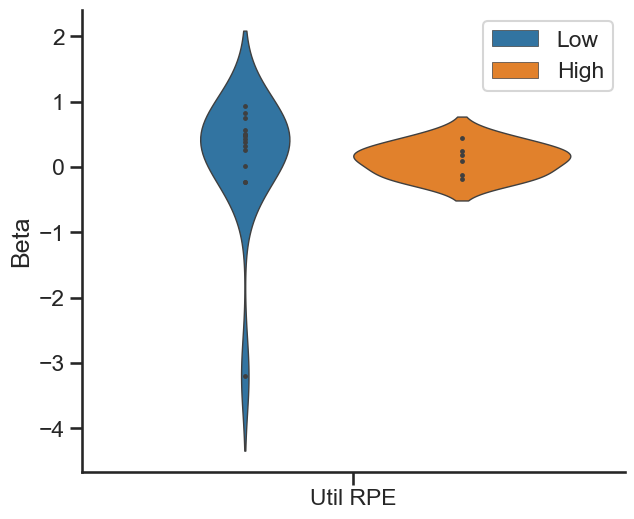

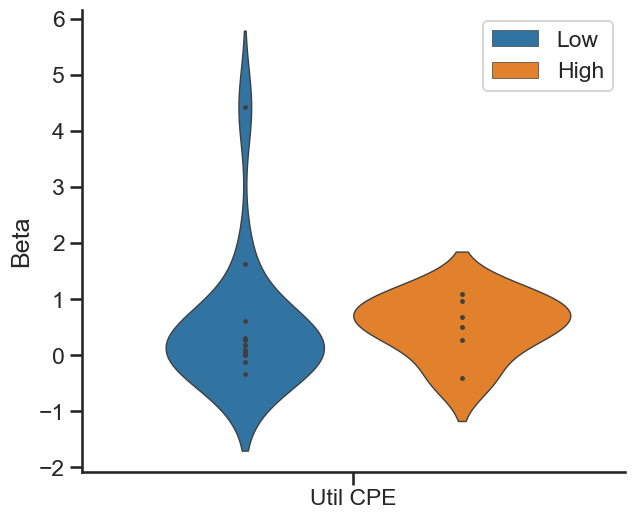

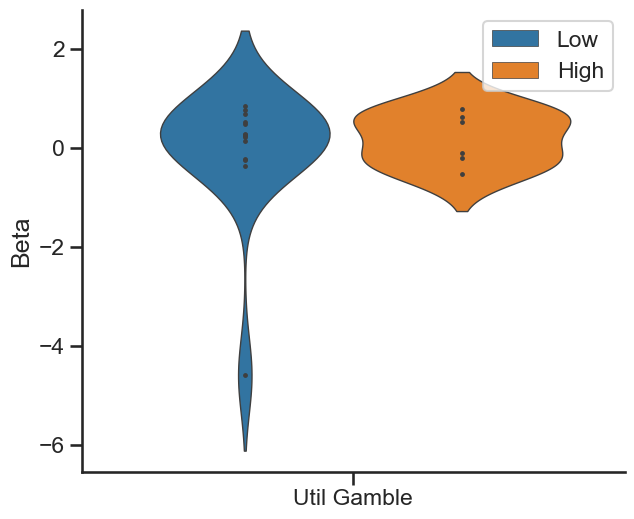

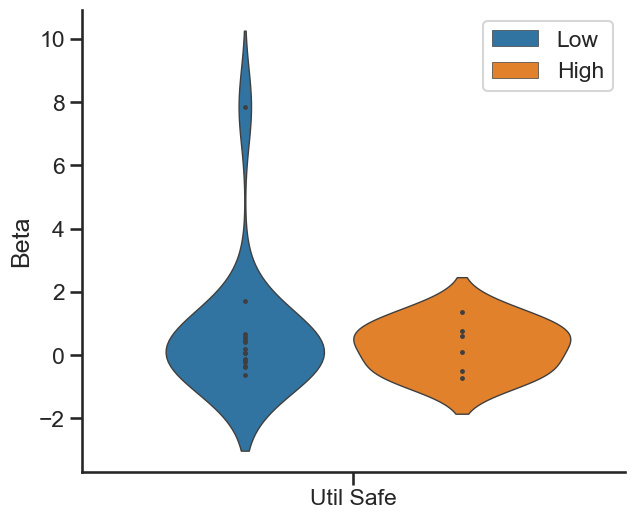

In [227]:
np.unique(bdi_cpe_rpe_util_data.Var_ID)
plot_vars = ['util_RPE_emmap', 'util_dCPE_emmap', 'util_gamble_emmap',
       'util_safe_emmap']

for var in plot_vars:

    model_id = model_id = bdi_cpe_rpe_util_data.Model[0]
    plot_data = bdi_cpe_rpe_util_data[(bdi_cpe_rpe_util_data.Var_ID == var)]

    fig, ax = plt.subplots(figsize=(7, 6))

    sns.violinplot(ax=ax,
        data=plot_data, x='Regressor', y="Beta", hue='BDI',palette='tab10',
        scale='area',split=False,linewidth=1,legend=False,inner='point')#errwidth=0)
    ax.legend()
    ax.set(xlabel=None)

    
    sns.despine() 


    plt.savefig(f'{fig_dir}{model_id}_{var}_bdi_betas_{date}.pdf', dpi=500, format='pdf', metadata=None,
    bbox_inches='tight', pad_inches=0.2,
    facecolor='auto', edgecolor='auto',
    backend=None) 

In [ ]:
#### stats for future - 
# from scipy.stats import mannwhitneyu, normaltest
# dep = cpe_vars.loc[(cpe_vars.BDI == "High"), "Beta"].values
# ndep = cpe_vars.loc[(cpe_vars.BDI == "Low"), "Beta"].values

# mannwhitneyu(dep, ndep, alternative="two-sided")
# stat_results = [
#   mannwhitneyu(robots, flight, alternative="two-sided"),
#   mannwhitneyu(flight, sound, alternative="two-sided"),
#   mannwhitneyu(robots, sound, alternative="two-sided")
# ]

# pvalues = [result.pvalue for result in stat_results]

# print("Robots vs Flight: \n", stat_results[0], "\n")
# print("Flight vs Sound: \n", stat_results[1], "\n")
# print("robots vs Sound: \n", stat_results[2], "\n")

# pvalues = [
#     sci_stats.mannwhitneyu(robots, flight, alternative="two-sided").pvalue,
#     sci_stats.mannwhitneyu(flight, sound, alternative="two-sided").pvalue,
#     sci_stats.mannwhitneyu(robots, sound, alternative="two-sided").pvalue
# ]
# # Transform each p-value to "p=" in scientific notation
# formatted_pvalues = [f'p={pvalue:.2e}' for pvalue in pvalues]
# annotator.set_custom_annotations(formatted_pvalues) 

# # Putting the parameters in a dictionary avoids code duplication
# # since we use the same for `sns.boxplot` and `Annotator` calls
# plotting_parameters = {
#     'data':    rfs,
#     'x':       'Subcategory',
#     'y':       'Goal',
#     'palette': subcat_palette[1:]
# }

# pairs = [('Robots', 'Flight'),
#          ('Flight', 'Sound'),
#          ('Robots', 'Sound')]

# with sns.plotting_context('notebook', font_scale = 1.4):
#     # Create new plot
#     ax = get_log_ax()

#     # Plot with seaborn
#     sns.boxplot(**plotting_parameters)

#     # Add annotations
#     annotator = Annotator(ax, pairs, **plotting_parameters)
#     annotator.set_custom_annotations(formatted_pvalues)
#     annotator.annotate()

#     # Label and show
#     label_plot_for_subcats(ax)
#     plt.show()
# #https://levelup.gitconnected.com/statistics-on-seaborn-plots-with-statannotations-2bfce0394c00


In [50]:
cpe_vars.groupby(['BDI'])['Beta'].describe()

count      mean       std       min       25%       50%       75%  \
BDI                                                                       
High    6.0  0.181726  0.243153 -0.151229  0.040810  0.205611  0.276235   
Low    15.0  0.039219  0.254261 -0.437676 -0.058938  0.021931  0.082441   

           max  
BDI             
High  0.544710  
Low   0.800183

In [ ]:
from scipy.stats import mannwhitneyu
U1, p = mannwhitneyu(cpe_vars., females, method="exact")
print(U1)

<Axes: xlabel='Regressor', ylabel='Beta'>

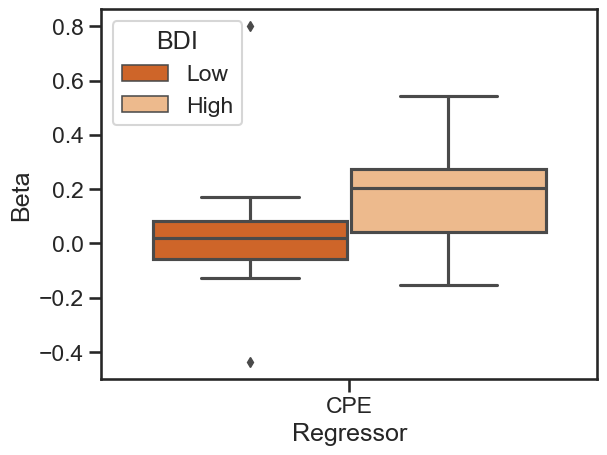

In [48]:
sns.boxplot(data=cpe_vars, x='Regressor',y='Beta', hue='BDI',palette='Oranges_r')


In [651]:
# sns.displot(data=bdi_cpe_rpe_base_data, x="Beta", hue="Regressor", kind="kde")

/Users/alexandrafink/opt/anaconda3/envs/swb_behav_models/lib/python3.11/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.2980392156862745, 0.4470588235294118, 0.6901960784313725)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/alexandrafink/opt/anaconda3/envs/swb_behav_models/lib/python3.11/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.8666666666666667, 0.5176470588235295, 0.3215686274509804)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,


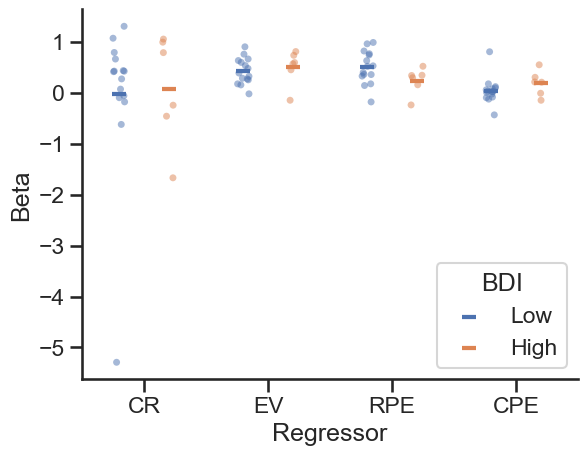

In [44]:
sns.stripplot(
    data=bdi_cpe_rpe_base_data,  x="Regressor", y="Beta", hue='BDI',
    dodge=True, alpha=.5, legend=False,native_scale=False)
sns.pointplot(
    data=bdi_cpe_rpe_base_data, x="Regressor", y="Beta", hue='BDI',
    dodge=.4, linestyles='none',errorbar=None,
    markers="_")
sns.despine()

# plt.savefig(f'{fig_dir}glm_bic_util_comp_{date}.pdf', dpi=500, format='pdf', metadata=None,
# bbox_inches='tight', pad_inches=0.2,
# facecolor='auto', edgecolor='auto',
# backend=None) 

<Axes: xlabel='Regressor', ylabel='Beta'>

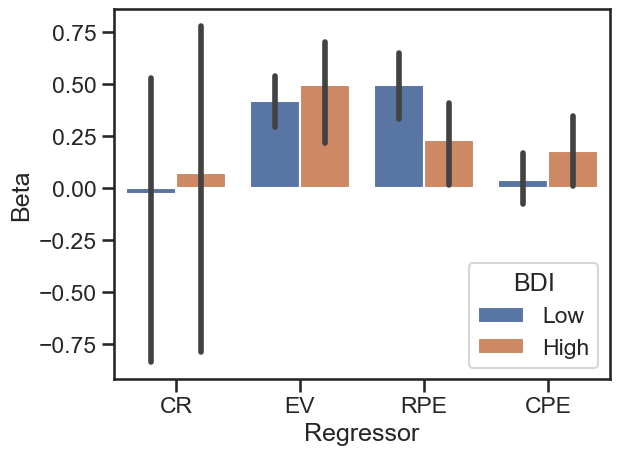

In [45]:
sns.barplot(
    data=bdi_cpe_rpe_base_data, x="Regressor", y="Beta", hue='BDI')#errwidth=0)

In [46]:
cpe_vars = bdi_cpe_rpe_base_data[bdi_cpe_rpe_base_data.Regressor=='CPE']

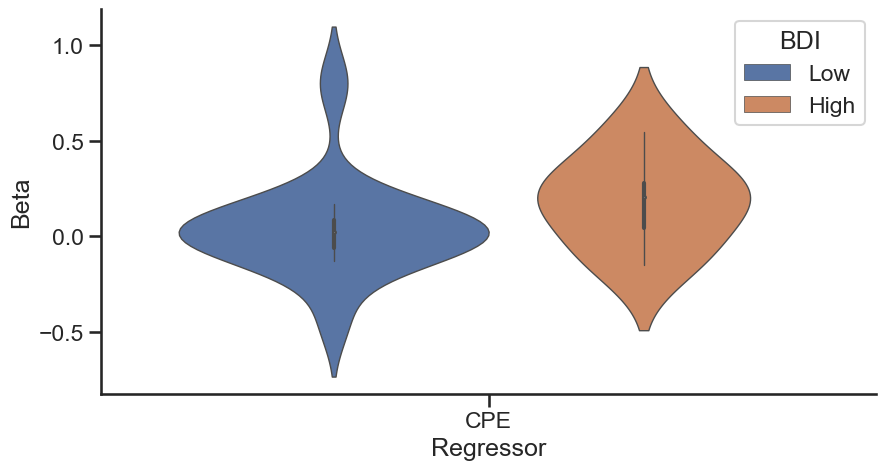

In [747]:
fig, ax = plt.subplots(figsize=(10, 5))


sns.violinplot(ax=ax,
    data=cpe_vars, x="Regressor", y="Beta", hue='BDI',native_scale=False,
    density_norm='width',split=False,linewidth=1)#errwidth=0)


sns.despine() 



# plt.savefig(f'{fig_dir}glm_bic_util_bars_{date}.pdf', dpi=500, format='pdf', metadata=None,
# bbox_inches='tight', pad_inches=0.2,
# facecolor='auto', edgecolor='auto',
# backend=None) 

<Axes: xlabel='Regressor', ylabel='Beta'>

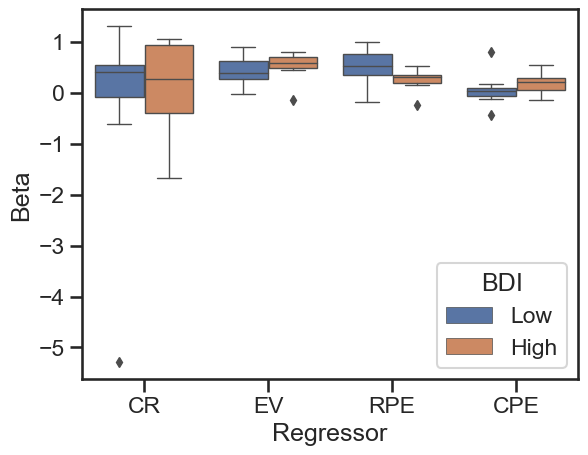

In [739]:
sns.boxplot(
    data=bdi_cpe_rpe_base_data,  x="Regressor", y="Beta", hue='BDI',
    dodge=True,linewidth=1)
    # dodge=True, alpha=0.9, legend=False)

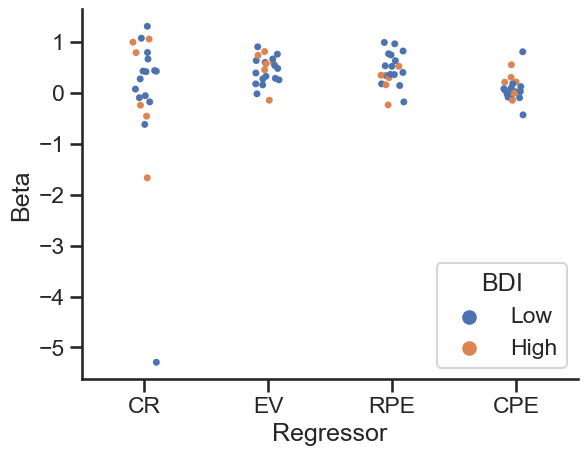

In [716]:
sns.stripplot(
    data=bdi_cpe_rpe_base_data,  x="Regressor", y="Beta", hue='BDI',
    dodge=True, alpha=0.9, legend=False)

# sns.boxplot(
#     data=bdi_cpe_rpe_base_data, x="Regressor", y="Beta", hue='BDI')#errwidth=0)

sns.despine() 

# plt.savefig(f'{fig_dir}glm_bic_util_bars_{date}.pdf', dpi=500, format='pdf', metadata=None,
# bbox_inches='tight', pad_inches=0.2,
# facecolor='auto', edgecolor='auto',
# backend=None) 


In [ ]:
# # make base vs util bic comparison dfs
#     # all subj BIC data for each model from all_results_dict
#     # df with cols x = regressor name, y = BIC, color = util vs base 

# # list of model names for comparison (selected from lowest BIC for each param) - grouped into tuples by regressor type

# bdi_plot_models_list = [('Base','Base_util'),
#                               ('RPE','RPE_util'),
#                               ('dCPE','dCPE_util'),
#                               ('dRegret','dRegret_util'),
#                               ('dRelief','dRelief_util'),
#                               ('RPE_dCPE','dCPE_RPE_util')
#                               ('nRPE_dReg_pRPE_dRel','nRPE_pRPE_dReg_dRel_util')]

# bdi_plot_regressor_cats = ['Choice','RPE','CPE','Regret','Relief','RPE_CPE','Full']
# bdi_plot_color_cats = ['Base','Utility']


In [ ]:
# # iterate through plot models list - 

# base_util_plot_dict = {} # should contain reg cat, color cat, 
# base_util_plot_data = pd.DataFrame(columns=['Model','Regressor','BIC','Type']) 

# for ix,model_names in enumerate(base_util_plot_models_list):
#     #regressor name is same for both models
#     reg_name = base_util_plot_regressor_cats[ix]
#     #model var info - name, category for color
#     for x in range(len(model_names)):
#         name  = model_names[x] #first item in tuple will be base model name 
#         color = base_util_plot_color_cats[x]# hard coded since there are so few options
#         bic   = all_results_dict[name].bic
#         model_plot_dict = {'Regressor':[reg_name]*len(bic),'Type':[color]*len(bic),
#                                      'Model':[name]*len(bic),'BIC':bic}
#         base_util_plot_dict[name] = model_plot_dict
#         base_util_plot_data = pd.concat([base_util_plot_data,pd.DataFrame(model_plot_dict)])

References:
- https://shawnrhoads.github.io/gu-psyc-347/module-02-01_Nonlinear-Modeling.html
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html
- https://hernandis.me/2020/04/05/three-examples-of-nonlinear-least-squares-fitting-in-python-with-scipy.html
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html#scipy.optimize.OptimizeResult
- https://www.nedcharles.com/regression/Nonlinear_Least_Squares_Regression_For_Python.html
